# Data Exploration and Model Building

Train data contains 72983 samples and 34 columns for each sample. Test data contains 48707 samples, and 33 coulmns for each sample.

## Data Type
Before we explore the dataset, we want to comfirm the data type for each column.

In [1]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from datetime import datetime
import warnings
import random
import lightgbm as lgb
%matplotlib inline 
warnings.filterwarnings('ignore')

In [2]:
train_data = pd.read_csv('../data/training.csv')
test_data = pd.read_csv('../data/test.csv')

In [3]:
# Trim feature is highly correlated to Model and SubModel, and it contains lots of missing value
train_data.drop(['Trim'], axis=1, inplace=True)
test_data.drop(['Trim'], axis=1, inplace=True)

# WheelTypeId is duplicate of WheelType
train_data.drop(['WheelTypeID'], axis=1, inplace=True)
test_data.drop(['WheelTypeID'], axis=1, inplace=True)

# VehYear is duplicate of VehicleAge
train_data.drop(['VehYear'], axis=1, inplace=True)
test_data.drop(['VehYear'], axis=1, inplace=True)

In [4]:
train_data_y = train_data['IsBadBuy']
train_data_x = train_data.drop(['RefId', 'IsBadBuy'], axis=1)

In [5]:
test_idx = test_data['RefId']
test_data_x = test_data.drop(['RefId'], axis=1)

## Missing Values Imputation
Both train data and test data contain missing values, and we need to do missing value imputation for both of them. Thus, I combine the features in train and test dataset together and then do missing value imputation for the combined feature data frame. To mimic typo, I transfer all string in the dataframe to uppercase.

In [6]:
features = pd.concat([train_data_x, test_data_x])

In [7]:
for col in features.select_dtypes(include=["object"]).columns.values:
    features[col] = features[col].str.upper()
    

#### Check Feature Data Type

In [8]:
features.select_dtypes(include=["float64", "int64"]).columns.values

array(['VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionAuctionCleanPrice',
       'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
       'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
       'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice',
       'BYRNO', 'VNZIP1', 'VehBCost', 'IsOnlineSale', 'WarrantyCost'], dtype=object)

In [9]:
features.select_dtypes(include=["object"]).columns.values

array(['PurchDate', 'Auction', 'Make', 'Model', 'SubModel', 'Color',
       'Transmission', 'WheelType', 'Nationality', 'Size',
       'TopThreeAmericanName', 'PRIMEUNIT', 'AUCGUART', 'VNST'], dtype=object)

#### Check NaN Values

In [10]:
features.isnull().sum()

PurchDate                                 0
Auction                                   0
VehicleAge                                0
Make                                      0
Model                                     0
SubModel                                 13
Color                                    12
Transmission                             12
WheelType                              5362
VehOdo                                    0
Nationality                              12
Size                                     12
TopThreeAmericanName                     12
MMRAcquisitionAuctionAveragePrice        28
MMRAcquisitionAuctionCleanPrice          28
MMRAcquisitionRetailAveragePrice         28
MMRAcquisitonRetailCleanPrice            28
MMRCurrentAuctionAveragePrice           458
MMRCurrentAuctionCleanPrice             458
MMRCurrentRetailAveragePrice            458
MMRCurrentRetailCleanPrice              458
PRIMEUNIT                            115755
AUCGUART                        

#### Missing value in SubModel, Transmission, WheelType

**Model, SubModel, Transmission, WheelType**, these 4 features are correlated. Transmission and WheelType could be infered by Model and SubModel. SubModel could be refered from Model. Thus, We can fill the missing values in these features based on the values in the other features.

In [11]:
# Fill missing values in SubModel
features.loc[[24567, 24578], 'SubModel'] = '4D SEDAN SXT FFV'
features.loc[[70432], 'SubModel'] = 'REG CAB 2.2L FFV'
features.loc[[70434], 'SubModel'] = '4D SEDAN'
features.loc[[70437], 'SubModel'] = '4D SEDAN SE'
features.loc[[70445], 'SubModel'] = '2D COUPE'
features.loc[[70446], 'SubModel'] = '4D SUV 4.6L'
features.loc[[70450], 'SubModel'] = 'PASSENGER 3.9L SE'
features.loc[[19863], 'SubModel'] = 'SPORT UTILITY'
features.loc[[19864], 'SubModel'] = '4D SUV LS'
features.loc[[19867], 'SubModel'] = '4D SEDAN CLASSIC'
features.loc[[30915], 'SubModel'] = 'MINIVAN 3.3L'
features.loc[[37737], 'SubModel'] = '4D SEDAN'

In [12]:
# Fill missing values in Transmission
features.loc[[15906, 19863, 19864, 19867, 24567, 24578, 70432, 70434, 70437, 70445, 70446, 70450],["Transmission"]]="AUTO"

In [13]:
# Fill missing values in WheelType
for index, row in features.iterrows():
    if str(row['WheelType']) == 'nan':
        tmp = features[(features['Model'] == row['Model'])
                       & (features['SubModel'] == row['SubModel'])]['WheelType'].value_counts()
        if (tmp.size > 0):
            features.loc[[index], 'WheelType'] = tmp.index[0]
        else:
            features.loc[[index], 'WheelType'] = 'ALLOY'

#### Missing value in Color

In [14]:
# Fill missing values in Color using Mode
features.loc[features['Color'].isnull(), 'Color'] = 'SILVER'
features.loc[features['Color'] == 'NOT AVAIL', 'Color'] = 'SILVER'

#### Missing value in Nationality, Size, TopThreeAmericanName
The missing values in these 3 features are tied together, they are not randomly missing

In [15]:
features[features['Nationality'].isnull()][['Model', 'SubModel', 'Nationality', 'Size', 'TopThreeAmericanName']]

,Model,SubModel,Nationality,Size,TopThreeAmericanName
10888,SIERRA 1500,BASE,NaN,NaN,NaN
25169,NITRO 4WD V6,4D SUV 3.7L SE,NaN,NaN,NaN
37986,ELANTRA 2.0L I4 MPI,4D SEDAN,NaN,NaN,NaN
69948,PATRIOT 2WD 4C,4D SUV SPORT,NaN,NaN,NaN
69958,PATRIOT 2WD 4C,4D SUV SPORT,NaN,NaN,NaN
2082,NITRO 4WD V6,4D SUV 3.7L SE,NaN,NaN,NaN
20588,NEON 2.0L I4 SFI,4D SEDAN,NaN,NaN,NaN
20589,ALTIMA 2.5L I4 EFI,4D SEDAN S,NaN,NaN,NaN
20594,GRAND AM V6 3.4L V6,4D SEDAN SE,NaN,NaN,NaN
20595,DURANGO 4WD V8 4.7L,4D SUV 4.7L SLT,NaN,NaN,NaN


In [16]:
features.loc[[10888], 'Nationality'] = 'AMERICAN'
features.loc[[10888], 'Size'] = 'LARGE TRUCK'
features.loc[[10888], 'TopThreeAmericanName'] = 'GM'
features.loc[[25169, 2082], 'Nationality'] = 'AMERICAN'
features.loc[[25169, 2082], 'Size'] = 'MEDIUM SUV'
features.loc[[25169, 2082], 'TopThreeAmericanName'] = 'CHRYSLER'
features.loc[[37986], 'Nationality'] = 'OTHER ASIAN'
features.loc[[37986], 'Size'] = 'MEDIUM'
features.loc[[37986], 'TopThreeAmericanName'] = 'OTHER'
features.loc[[69948, 69958], 'Nationality'] = 'AMERICAN'
features.loc[[69948, 69958], 'Size'] = 'SMALL SUV'
features.loc[[69948, 69958], 'TopThreeAmericanName'] = 'CHRYSLER'
features.loc[[20588], 'Nationality'] = 'AMERICAN'
features.loc[[20588], 'Size'] = 'LARGE TRUCK'
features.loc[[20588], 'TopThreeAmericanName'] = 'CHRYSLER'
features.loc[[20589], 'Nationality'] = 'AMERICAN'
features.loc[[20589], 'Size'] = 'MEDIUM SUV'
features.loc[[20589], 'TopThreeAmericanName'] = 'GM'
features.loc[[20594], 'Nationality'] = 'AMERICAN'
features.loc[[20594], 'Size'] = 'COMPACT'
features.loc[[20594], 'TopThreeAmericanName'] = 'GM'
features.loc[[20595], 'Nationality'] = 'AMERICAN'
features.loc[[20595], 'Size'] = 'LARGE'
features.loc[[20595], 'TopThreeAmericanName'] = 'FORD'
features.loc[[20597], 'Nationality'] = 'AMERICAN'
features.loc[[20597], 'Size'] = 'MEDIUM'
features.loc[[20597], 'TopThreeAmericanName'] = 'GM'
features.loc[[20600], 'Nationality'] = 'AMERICAN'
features.loc[[20600], 'Size'] = 'MEDIUM'
features.loc[[20600], 'TopThreeAmericanName'] = 'CHRYSLER'

#### Missing value in MMRAcquisitionAuctionAveragePrice, MMRAcquisitionAuctionCleanPrice, MMRAcquisitionRetailAveragePrice, MMRAcquisitonRetailCleanPrice
The missing values in these 4 features are tied together. It seems to be non-randomly missing. Due to time limit, I would use mean value to replace the nan.

In [17]:
# MMRAcquisitionAuctionAveragePrice
mean_auc_avg_price = features['MMRAcquisitionAuctionAveragePrice'].dropna().values.mean()
features.loc[features['MMRAcquisitionAuctionAveragePrice'].isnull(),
             'MMRAcquisitionAuctionAveragePrice'] = mean_auc_avg_price

# MMRAcquisitionAuctionCleanPrice
mean_auc_clean_price = features['MMRAcquisitionAuctionCleanPrice'].dropna().values.mean()
features.loc[features['MMRAcquisitionAuctionCleanPrice'].isnull(),
             'MMRAcquisitionAuctionCleanPrice'] = mean_auc_clean_price

# MMRAcquisitionRetailAveragePrice
mean_retail_avg_price = features['MMRAcquisitionRetailAveragePrice'].dropna().values.mean()
features.loc[features['MMRAcquisitionRetailAveragePrice'].isnull(),
             'MMRAcquisitionRetailAveragePrice'] = mean_retail_avg_price

# MMRAcquisitonRetailCleanPrice
mean_retail_clean_price = features['MMRAcquisitonRetailCleanPrice'].dropna().values.mean()
features.loc[features['MMRAcquisitonRetailCleanPrice'].isnull(),
             'MMRAcquisitonRetailCleanPrice'] = mean_retail_clean_price


#### Missing value in MMRCurrentAuctionAveragePrice, MMRCurrentAuctionCleanPrice, MMRCurrentRetailAveragePrice, MMRCurrentRetailCleanPrice
The missing values in these 4 features are tied together. It seems to be non-randomly missing. Due to time limit, I would use mean value to replace the nan.

In [18]:
# MMRAcquisitionAuctionAveragePrice
mean_auc_avg_price = features['MMRCurrentAuctionAveragePrice'].dropna().values.mean()
features.loc[features['MMRCurrentAuctionAveragePrice'].isnull(),
             'MMRCurrentAuctionAveragePrice'] = mean_auc_avg_price

# MMRAcquisitionAuctionCleanPrice
mean_auc_clean_price = features['MMRCurrentAuctionCleanPrice'].dropna().values.mean()
features.loc[features['MMRCurrentAuctionCleanPrice'].isnull(),
             'MMRCurrentAuctionCleanPrice'] = mean_auc_clean_price

# MMRAcquisitionRetailAveragePrice
mean_retail_avg_price = features['MMRCurrentRetailAveragePrice'].dropna().values.mean()
features.loc[features['MMRCurrentRetailAveragePrice'].isnull(),
             'MMRCurrentRetailAveragePrice'] = mean_retail_avg_price

# MMRAcquisitonRetailCleanPrice
mean_retail_clean_price = features['MMRCurrentRetailCleanPrice'].dropna().values.mean()
features.loc[features['MMRCurrentRetailCleanPrice'].isnull(),
             'MMRCurrentRetailCleanPrice'] = mean_retail_clean_price

#### Missing value in PRIMEUNIT, AUCGUART
As the values of these 2 features in most samples are nan, I would create a new level for these two features

In [19]:
features.loc[features['PRIMEUNIT'].isnull(), 'PRIMEUNIT'] = 'OTHER'
features.loc[features['AUCGUART'].isnull(), 'AUCGUART'] = 'OTHER'

## Imbalanced Dataset
After missing value imputation, I want to explore is the distribution of the targets. Based on the results, we find that the distribution of target _**IsBadBuy**_ is  imbalanced. Most of the samples are 0 and only around 12% of the samples in the training dataset are 1. As most machine learning or deep learning mdoels do not work well for imbalanced data, some methods may be used to handle the unbalance labels in our project:
1. Downsampling the samples whose IsBadBuy = 0
2. Upsampling the samples whose IsBadBuy = 1
3. Modify the loss function, increase the loss for samples with IsBadBuy=1, and decrease the loss for samples with IsBadBuy=0
4. Use some evaluation metric that could handle imbalance classes, such as AUC. For this dataset, if accurately predicting IsBadBuy=1 is more important and we can endure more false positive, could choose recall to evaluate the model
5. Assemble several different classifier using some ensemble methods, such as cascade method

In [20]:
train_data['IsBadBuy'].value_counts()

0    64007
1     8976
Name: IsBadBuy, dtype: int64

# Extract features
* Features may influence the WarrantyCost and VehBCost  
  * AuctionAverageChange: Auction average price change from acquisition to current
  * AuctionCleanChange: Auction clean price change from acquisition to current
  * RetailAverageChange: Retail average price change from acquisition to current
  * RetailCleanChange: Retail clean price change from acquisition to current
  * AcqRetailAuctionAverageDiff: The retail and auction average price difference at acquisition time
  * AcqRetailAuctionCleanDiff: The retail and auction clean price difference at acquisition time
  * CurRetailAuctionAverageDiff: The current retail and auction average price difference
  * CurRetailAuctionCleanDiff: The current retail and auction clean price difference
* OdoPerYear: Average odometer reading per year, the higher it is, maybe the higher risk that it's bad kicked car
* AcqBCostAvgDiff: The difference between acquisition cost and average acqusition cost
* AcqBCostCleanDiff: The difference between acquisition cost and clean acqusition cost
* AcqWarrantyCostDiff: The difference between WarrantyCost and VehBCost

In [21]:
# Odometer reading Per Year
features['OdoPerYear'] = features['VehOdo'] / (features['VehicleAge'] + 1)

features['AuctionAverageChange'] = features['MMRCurrentAuctionAveragePrice'] - features['MMRAcquisitionAuctionAveragePrice']
features['AuctionCleanChange'] = features['MMRCurrentAuctionCleanPrice'] - features['MMRAcquisitionAuctionCleanPrice']
features['RetailAverageChange'] = features['MMRCurrentRetailAveragePrice'] - features['MMRAcquisitionRetailAveragePrice']
features['RetailCleanChange'] = features['MMRCurrentRetailCleanPrice'] - features['MMRAcquisitonRetailCleanPrice']
features['AcqRetailAuctionAverageDiff'] = features['MMRAcquisitionRetailAveragePrice'] - features['MMRAcquisitionAuctionAveragePrice']
features['AcqRetailAuctionCleanDiff'] = features['MMRAcquisitonRetailCleanPrice'] - features['MMRAcquisitionAuctionCleanPrice']
features['CurRetailAuctionAverageDiff'] = features['MMRCurrentRetailAveragePrice'] - features['MMRCurrentAuctionAveragePrice']
features['CurRetailAuctionCleanDiff'] = features['MMRCurrentRetailCleanPrice'] - features['MMRCurrentAuctionCleanPrice']

features['AcqBCostAvgDiff'] = features['MMRAcquisitionAuctionAveragePrice'] - features['VehBCost']
features['AcqBCostCleanDiff'] = features['MMRCurrentAuctionCleanPrice'] - features['VehBCost']
features['AcqWarrantyCostDiff'] = features['WarrantyCost'] - features['VehBCost']

# Handle Categorical Features
We would try to conver categorical features into numerical features or reduce the levels of the categorical features. If the categorical features need to do one-hot encoding, we would do it after we normalize all numerical features.

#### VNZIP1, Model, SubModel
These three features, VNZIP1, Model, SubModel, has too many levels. Using one-hot encoding would lead to very sparse dataset. Thus we would not do one-hot encoding for these two features. To convert them into numerical features, I would use **the percentage of IsBadBuy=1 in each level** to replace the categories.

In [22]:
# Zipcode: VNZIP1
avg_percentage = 0.12298754504473644
zipcodes = features['VNZIP1'].value_counts().index.tolist()
for zipcode in zipcodes:
    tmp = train_data[train_data['VNZIP1'] == zipcode]['IsBadBuy'].value_counts().to_dict()
    if len(tmp) == 2:
        percentage = tmp[1] / (tmp[0] + tmp[1])
    elif len(tmp) == 1:
        if 1 in tmp:
            percentage = 1
        else:
            percentage = 0
    else:
        percentage = avg_percentage
    features.loc[features['VNZIP1'] == zipcode, 'VNZIP1'] = percentage

In [23]:
# Model
avg_percentage = 0.12298754504473644
models = features['Model'].value_counts().index.tolist()
for model in models:
    tmp = train_data[train_data['Model'] == model]['IsBadBuy'].value_counts().to_dict()
    if len(tmp) == 2:
        percentage = tmp[1] / (tmp[0] + tmp[1])
    elif len(tmp) == 1:
        if 1 in tmp:
            percentage = 1
        else:
            percentage = 0
    else:
        percentage = avg_percentage
    features.loc[features['Model'] == model, 'Model'] = percentage

In [24]:
# SubModel
avg_percentage = 0.12298754504473644
sub_models = features['SubModel'].value_counts().index.tolist()
for sub_model in sub_models:
    tmp = train_data[train_data['SubModel'] == sub_model]['IsBadBuy'].value_counts().to_dict()
    if len(tmp) == 2:
        percentage = tmp[1] / (tmp[0] + tmp[1])
    elif len(tmp) == 1:
        if 1 in tmp:
            percentage = 1
        else:
            percentage = 0
    else:
        percentage = avg_percentage
    features.loc[features['SubModel'] == sub_model, 'SubModel'] = percentage

#### Replace PurchDate to seconds from the earliest PurchDate

In [25]:
features['PurchDate'] = (pd.to_datetime(features['PurchDate'], format="%m/%d/%Y")
                         - pd.datetime(2009,12,7)).dt.total_seconds()

#### Reduce the level in Make and VNST

In [26]:
reduce_make_list = features['Make'].value_counts().index.tolist()[-15:]
features.loc[features['Make'].isin(reduce_make_list), 'Make'] = 'OTHER'

In [27]:
reduce_vnst_list = features['VNST'].value_counts().index.tolist()[-18:]
features.loc[features['VNST'].isin(reduce_vnst_list), 'VNST'] = 'OTHER'

## Explore Numerical Features
The distributions of most numerical features are close to Gaussian Distribution.

In [28]:
numeric_features = features.select_dtypes(include=["float64", "int64"]).columns.values.tolist()
numeric_features.remove('IsOnlineSale')

In [29]:
# Normalize features into range (0, 1)
min_max_scaler = preprocessing.MinMaxScaler()
for feature in numeric_features:
    tmp = features[feature].values
    scaled = min_max_scaler.fit_transform(tmp)
    features[feature] = scaled

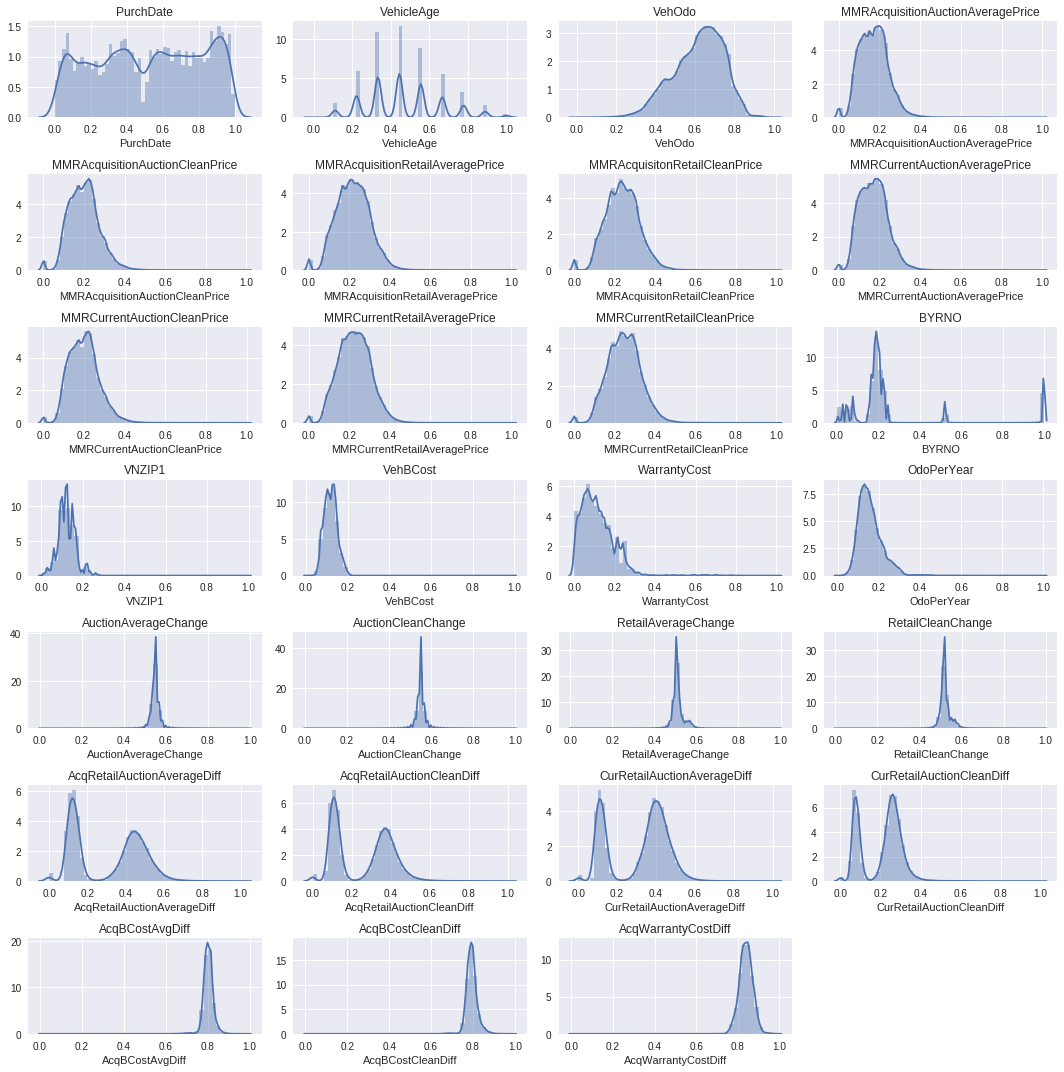

In [30]:
plt.figure(figsize=(15, 15))
for i in range(27):
    plt.subplot(7, 4, i + 1)
    sns.distplot(features[numeric_features[i]])
    plt.title(numeric_features[i])
plt.tight_layout()
plt.show()

# Change Categorical Features Data Type

In [31]:
cat_features = features.select_dtypes(include=["object"]).columns.values
encoder = preprocessing.LabelEncoder()
for cat_feature in cat_features:
    features[cat_feature] = encoder.fit_transform(features[cat_feature])
    features[cat_feature] = features[cat_feature].astype('category')
features['IsOnlineSale'] = features['IsOnlineSale'].astype('category')

# Balance Train Data
I would do downsampling to the samples whose IsBadBuy = 0 and upsampling to the samples whose IsBadBuy = 1

In [32]:
train_data_x = features.iloc[:72983]
test_data_x = features.iloc[72983:]

# Downsampling
good_buy = train_data_x[train_data_y.isin([0])].index.tolist()
good_buy = np.random.choice(good_buy, 15000).tolist()

# Upsampling
bad_buy = train_data_x[train_data_y.isin([1])].index.tolist()
bad_buy = np.random.choice(bad_buy, 10000).tolist()

# Randomly shuffle
selected_data = good_buy + bad_buy
random.shuffle(selected_data)

train_data_x = train_data_x.iloc[selected_data]
train_data_y = train_data_y.iloc[selected_data]

# Create LightGBM Dataset

# Feature Importance
I would use GBM to evaluate the feature importance and then based on the feature importance to select important features. The 

In [33]:
base_classifier = lgb.LGBMClassifier(num_leaves=127, max_depth=8, learning_rate=0.1, n_estimators=500,
                                     max_bin=255, subsample_for_bin=20, objective='binary', min_split_gain=0.0, 
                                     min_child_weight=2, min_child_samples=10, subsample=0.7, subsample_freq=1, 
                                     colsample_bytree=0.7, reg_alpha=0.01, reg_lambda=0.1)


base_booster = base_classifier.fit(train_data_x, train_data_y)

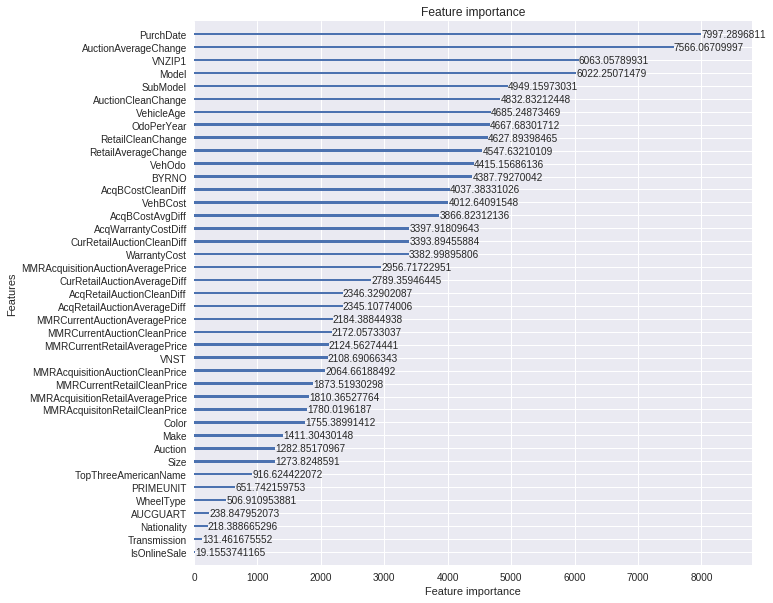

In [35]:
fig, ax = plt.subplots(figsize=(10, 10))
lgb.plot_importance(base_booster, height=0.2, importance_type='gain', ax=ax)

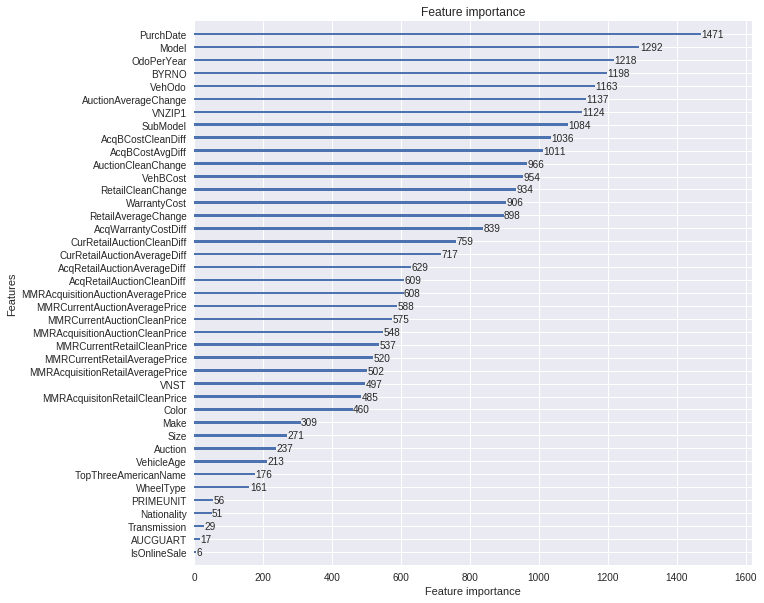

In [36]:
fig, ax = plt.subplots(figsize=(10, 10))
lgb.plot_importance(base_booster, height=0.2, importance_type='split', ax=ax)

In [37]:
selected_features = []
columns = train_data_x.columns.values
feature_importance = base_booster.feature_importances_
mean_importance = np.mean(feature_importance)
for i in range(len(columns)):
    if feature_importance[i] >= mean_importance:
        selected_features.append(columns[i])

In [38]:
selected_features

['PurchDate',
 'Model',
 'SubModel',
 'VehOdo',
 'BYRNO',
 'VNZIP1',
 'VehBCost',
 'WarrantyCost',
 'OdoPerYear',
 'AuctionAverageChange',
 'AuctionCleanChange',
 'RetailAverageChange',
 'RetailCleanChange',
 'CurRetailAuctionAverageDiff',
 'CurRetailAuctionCleanDiff',
 'AcqBCostAvgDiff',
 'AcqBCostCleanDiff',
 'AcqWarrantyCostDiff']

In [39]:
selected_train_data_x = train_data_x[selected_features]
selected_test_data_x = test_data_x[selected_features]

# Hyperparameter Tuning

#### Tune num_leaves, max_depth and min_child_weight

In [40]:
base_classifier = lgb.LGBMClassifier(learning_rate=0.1, n_estimators=500, max_bin=255, subsample_for_bin=20, objective='binary', min_split_gain=0.0, 
                                     min_child_samples=10, subsample=0.7, subsample_freq=1, 
                                     colsample_bytree=0.7, reg_alpha=0.01, reg_lambda=0.1)

gbm_params = {
    'num_leaves': [31, 63, 127, 256],
    'max_depth': [-1, 5, 6, 7, 8],
    'min_child_weight': [1, 2, 3, 4, 5]
}


grid = GridSearchCV(base_classifier, gbm_params,scoring='roc_auc',cv = 5,verbose=10,n_jobs=-1)

grid.fit(selected_train_data_x, train_data_y)

print (grid.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] max_depth=-1, min_child_weight=1, num_leaves=31 .................
[CV] max_depth=-1, min_child_weight=1, num_leaves=31 .................
[CV] max_depth=-1, min_child_weight=1, num_leaves=31 .................
[CV] max_depth=-1, min_child_weight=1, num_leaves=31 .................
[CV] max_depth=-1, min_child_weight=1, num_leaves=31 .................
[CV] max_depth=-1, min_child_weight=1, num_leaves=63 .................
[CV] max_depth=-1, min_child_weight=1, num_leaves=63 .................
[CV] max_depth=-1, min_child_weight=1, num_leaves=63 .................
[CV] max_depth=-1, min_child_weight=1, num_leaves=63 .................
[CV] max_depth=-1, min_child_weight=1, num_leaves=63 .................
[CV] max_depth=-1, min_child_weight=1, num_leaves=127 ................
[CV] max_depth=-1, min_child_weight=1, num_leaves=127 ................
[CV]  max_depth=-1, min_child_weight=1, num_leaves=31, score=0.879292, total=  29.4s


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   31.1s


[CV]  max_depth=-1, min_child_weight=1, num_leaves=31, score=0.884265, total=  29.8s
[CV] max_depth=-1, min_child_weight=1, num_leaves=127 ................
[CV]  max_depth=-1, min_child_weight=1, num_leaves=31, score=0.877778, total=  30.1s
[CV] max_depth=-1, min_child_weight=1, num_leaves=127 ................
[CV]  max_depth=-1, min_child_weight=1, num_leaves=31, score=0.878862, total=  32.0s
[CV] max_depth=-1, min_child_weight=1, num_leaves=256 ................
[CV]  max_depth=-1, min_child_weight=1, num_leaves=31, score=0.887840, total=  33.8s
[CV] max_depth=-1, min_child_weight=1, num_leaves=256 ................
[CV]  max_depth=-1, min_child_weight=1, num_leaves=63, score=0.899530, total=  58.1s
[CV] max_depth=-1, min_child_weight=1, num_leaves=256 ................
[CV]  max_depth=-1, min_child_weight=1, num_leaves=63, score=0.909166, total=  59.3s
[CV] max_depth=-1, min_child_weight=1, num_leaves=256 ................
[CV]  max_depth=-1, min_child_weight=1, num_leaves=63, score=0.9

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.0min


[CV]  max_depth=-1, min_child_weight=1, num_leaves=63, score=0.898345, total= 1.0min
[CV] max_depth=-1, min_child_weight=2, num_leaves=31 .................
[CV]  max_depth=-1, min_child_weight=1, num_leaves=63, score=0.906215, total= 1.1min
[CV] max_depth=-1, min_child_weight=2, num_leaves=31 .................
[CV]  max_depth=-1, min_child_weight=2, num_leaves=31, score=0.889146, total=  30.5s
[CV] max_depth=-1, min_child_weight=2, num_leaves=31 .................
[CV]  max_depth=-1, min_child_weight=2, num_leaves=31, score=0.880507, total=  31.2s
[CV] max_depth=-1, min_child_weight=2, num_leaves=31 .................
[CV]  max_depth=-1, min_child_weight=1, num_leaves=127, score=0.916122, total= 2.0min
[CV] max_depth=-1, min_child_weight=2, num_leaves=31 .................
[CV]  max_depth=-1, min_child_weight=2, num_leaves=31, score=0.876985, total=  31.0s
[CV] max_depth=-1, min_child_weight=2, num_leaves=63 .................
[CV]  max_depth=-1, min_child_weight=1, num_leaves=127, score=0

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.5min


[CV]  max_depth=-1, min_child_weight=1, num_leaves=127, score=0.906049, total= 2.1min
[CV] max_depth=-1, min_child_weight=2, num_leaves=63 .................
[CV]  max_depth=-1, min_child_weight=2, num_leaves=31, score=0.885165, total=  34.5s
[CV] max_depth=-1, min_child_weight=2, num_leaves=127 ................
[CV]  max_depth=-1, min_child_weight=1, num_leaves=127, score=0.912850, total= 2.1min
[CV] max_depth=-1, min_child_weight=2, num_leaves=127 ................
[CV]  max_depth=-1, min_child_weight=2, num_leaves=63, score=0.896780, total=  57.6s
[CV] max_depth=-1, min_child_weight=2, num_leaves=127 ................
[CV]  max_depth=-1, min_child_weight=2, num_leaves=63, score=0.908274, total= 1.1min
[CV] max_depth=-1, min_child_weight=2, num_leaves=127 ................
[CV]  max_depth=-1, min_child_weight=2, num_leaves=63, score=0.898349, total= 1.1min
[CV] max_depth=-1, min_child_weight=2, num_leaves=127 ................
[CV]  max_depth=-1, min_child_weight=2, num_leaves=63, score=0

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.8min


[CV]  max_depth=-1, min_child_weight=1, num_leaves=256, score=0.907918, total= 3.2min
[CV] max_depth=-1, min_child_weight=2, num_leaves=256 ................
[CV]  max_depth=-1, min_child_weight=1, num_leaves=256, score=0.907439, total= 2.9min
[CV]  max_depth=-1, min_child_weight=1, num_leaves=256, score=0.914093, total= 2.9min
[CV] max_depth=-1, min_child_weight=2, num_leaves=256 ................
[CV] max_depth=-1, min_child_weight=3, num_leaves=31 .................
[CV]  max_depth=-1, min_child_weight=1, num_leaves=256, score=0.904915, total= 3.2min
[CV] max_depth=-1, min_child_weight=3, num_leaves=31 .................
[CV]  max_depth=-1, min_child_weight=3, num_leaves=31, score=0.888110, total=  31.2s
[CV] max_depth=-1, min_child_weight=3, num_leaves=31 .................
[CV]  max_depth=-1, min_child_weight=2, num_leaves=127, score=0.915136, total= 2.0min
[CV] max_depth=-1, min_child_weight=3, num_leaves=31 .................
[CV]  max_depth=-1, min_child_weight=3, num_leaves=31, scor

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  5.2min


[CV]  max_depth=-1, min_child_weight=3, num_leaves=31, score=0.878636, total=  30.6s
[CV] max_depth=-1, min_child_weight=3, num_leaves=63 .................
[CV]  max_depth=-1, min_child_weight=3, num_leaves=31, score=0.887602, total=  34.2s
[CV] max_depth=-1, min_child_weight=3, num_leaves=127 ................
[CV]  max_depth=-1, min_child_weight=2, num_leaves=127, score=0.908383, total= 2.2min
[CV] max_depth=-1, min_child_weight=3, num_leaves=127 ................
[CV]  max_depth=-1, min_child_weight=3, num_leaves=63, score=0.907796, total= 1.1min
[CV] max_depth=-1, min_child_weight=3, num_leaves=127 ................
[CV]  max_depth=-1, min_child_weight=3, num_leaves=63, score=0.894452, total= 1.0min
[CV] max_depth=-1, min_child_weight=3, num_leaves=127 ................
[CV]  max_depth=-1, min_child_weight=3, num_leaves=63, score=0.896143, total=  58.9s
[CV] max_depth=-1, min_child_weight=3, num_leaves=127 ................
[CV]  max_depth=-1, min_child_weight=3, num_leaves=63, score=0.

[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  6.6min


[CV]  max_depth=-1, min_child_weight=2, num_leaves=256, score=0.911168, total= 2.7min
[CV] max_depth=-1, min_child_weight=4, num_leaves=31 .................
[CV]  max_depth=-1, min_child_weight=2, num_leaves=256, score=0.903464, total= 2.9min
[CV] max_depth=-1, min_child_weight=4, num_leaves=31 .................
[CV]  max_depth=-1, min_child_weight=4, num_leaves=31, score=0.885635, total=  30.5s
[CV] max_depth=-1, min_child_weight=4, num_leaves=31 .................
[CV]  max_depth=-1, min_child_weight=4, num_leaves=31, score=0.877442, total=  33.4s
[CV] max_depth=-1, min_child_weight=4, num_leaves=31 .................
[CV]  max_depth=-1, min_child_weight=3, num_leaves=127, score=0.915089, total= 2.0min
[CV] max_depth=-1, min_child_weight=4, num_leaves=31 .................
[CV]  max_depth=-1, min_child_weight=3, num_leaves=127, score=0.901706, total= 2.2min
[CV] max_depth=-1, min_child_weight=4, num_leaves=63 .................
[CV]  max_depth=-1, min_child_weight=4, num_leaves=31, score

[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  8.6min


[CV]  max_depth=-1, min_child_weight=3, num_leaves=256, score=0.902837, total= 2.4min
[CV] max_depth=-1, min_child_weight=4, num_leaves=127 ................
[CV]  max_depth=-1, min_child_weight=3, num_leaves=256, score=0.901743, total= 2.4min
[CV] max_depth=-1, min_child_weight=4, num_leaves=127 ................
[CV]  max_depth=-1, min_child_weight=4, num_leaves=63, score=0.896105, total=  58.9s
[CV] max_depth=-1, min_child_weight=4, num_leaves=256 ................
[CV]  max_depth=-1, min_child_weight=3, num_leaves=256, score=0.898659, total= 2.3min
[CV] max_depth=-1, min_child_weight=4, num_leaves=256 ................
[CV]  max_depth=-1, min_child_weight=4, num_leaves=63, score=0.901951, total= 1.2min
[CV] max_depth=-1, min_child_weight=4, num_leaves=256 ................
[CV]  max_depth=-1, min_child_weight=4, num_leaves=63, score=0.896230, total=  58.5s
[CV] max_depth=-1, min_child_weight=4, num_leaves=256 ................
[CV]  max_depth=-1, min_child_weight=3, num_leaves=256, score

[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed: 10.2min


[CV]  max_depth=-1, min_child_weight=5, num_leaves=31, score=0.873284, total=  34.0s
[CV] max_depth=-1, min_child_weight=5, num_leaves=63 .................
[CV]  max_depth=-1, min_child_weight=4, num_leaves=127, score=0.900360, total= 1.8min
[CV] max_depth=-1, min_child_weight=5, num_leaves=63 .................
[CV]  max_depth=-1, min_child_weight=4, num_leaves=127, score=0.899335, total= 2.1min
[CV] max_depth=-1, min_child_weight=5, num_leaves=63 .................
[CV]  max_depth=-1, min_child_weight=4, num_leaves=127, score=0.907208, total= 1.7min
[CV] max_depth=-1, min_child_weight=5, num_leaves=63 .................
[CV]  max_depth=-1, min_child_weight=4, num_leaves=127, score=0.897054, total= 2.0min
[CV] max_depth=-1, min_child_weight=5, num_leaves=127 ................
[CV]  max_depth=-1, min_child_weight=5, num_leaves=31, score=0.885813, total=  34.5s
[CV] max_depth=-1, min_child_weight=5, num_leaves=127 ................
[CV]  max_depth=-1, min_child_weight=4, num_leaves=256, scor

[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed: 11.6min


[CV]  max_depth=-1, min_child_weight=5, num_leaves=63, score=0.898591, total= 1.0min
[CV] max_depth=5, min_child_weight=1, num_leaves=31 ..................
[CV]  max_depth=5, min_child_weight=1, num_leaves=31, score=0.850851, total=  14.5s
[CV] max_depth=5, min_child_weight=1, num_leaves=31 ..................
[CV]  max_depth=5, min_child_weight=1, num_leaves=31, score=0.847034, total=  14.7s
[CV] max_depth=5, min_child_weight=1, num_leaves=31 ..................
[CV]  max_depth=5, min_child_weight=1, num_leaves=31, score=0.836401, total=  14.6s
[CV] max_depth=5, min_child_weight=1, num_leaves=31 ..................
[CV]  max_depth=5, min_child_weight=1, num_leaves=31, score=0.846778, total=  14.1s
[CV] max_depth=5, min_child_weight=1, num_leaves=63 ..................
[CV]  max_depth=5, min_child_weight=1, num_leaves=31, score=0.847940, total=  14.4s
[CV] max_depth=5, min_child_weight=1, num_leaves=63 ..................
[CV]  max_depth=5, min_child_weight=1, num_leaves=63, score=0.851683,

[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 13.0min


[CV]  max_depth=5, min_child_weight=1, num_leaves=63, score=0.849201, total=  18.3s
[CV] max_depth=5, min_child_weight=1, num_leaves=256 .................
[CV]  max_depth=5, min_child_weight=1, num_leaves=127, score=0.851683, total=  16.9s
[CV] max_depth=5, min_child_weight=1, num_leaves=256 .................
[CV]  max_depth=5, min_child_weight=1, num_leaves=127, score=0.846221, total=  16.4s
[CV] max_depth=5, min_child_weight=1, num_leaves=256 .................
[CV]  max_depth=5, min_child_weight=1, num_leaves=127, score=0.836612, total=  15.4s
[CV] max_depth=5, min_child_weight=1, num_leaves=256 .................
[CV]  max_depth=5, min_child_weight=1, num_leaves=127, score=0.845154, total=  14.0s
[CV] max_depth=5, min_child_weight=2, num_leaves=31 ..................
[CV]  max_depth=5, min_child_weight=1, num_leaves=256, score=0.851683, total=  14.3s
[CV] max_depth=5, min_child_weight=2, num_leaves=31 ..................
[CV]  max_depth=5, min_child_weight=1, num_leaves=127, score=0.84

[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed: 13.6min


[CV]  max_depth=-1, min_child_weight=5, num_leaves=256, score=0.898703, total= 2.2min
[CV] max_depth=5, min_child_weight=2, num_leaves=127 .................
[CV]  max_depth=5, min_child_weight=2, num_leaves=31, score=0.849094, total=  17.0s
[CV] max_depth=5, min_child_weight=2, num_leaves=127 .................
[CV]  max_depth=-1, min_child_weight=5, num_leaves=256, score=0.896286, total= 2.2min
[CV] max_depth=5, min_child_weight=2, num_leaves=256 .................
[CV]  max_depth=5, min_child_weight=2, num_leaves=63, score=0.850973, total=  19.9s
[CV] max_depth=5, min_child_weight=2, num_leaves=256 .................
[CV]  max_depth=5, min_child_weight=2, num_leaves=63, score=0.848060, total=  13.8s
[CV] max_depth=5, min_child_weight=2, num_leaves=256 .................
[CV]  max_depth=5, min_child_weight=2, num_leaves=63, score=0.835730, total=  15.5s
[CV] max_depth=5, min_child_weight=2, num_leaves=256 .................
[CV]  max_depth=5, min_child_weight=2, num_leaves=63, score=0.8447

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 14.1min


[CV]  max_depth=5, min_child_weight=2, num_leaves=256, score=0.848060, total=  16.1s
[CV] max_depth=5, min_child_weight=3, num_leaves=127 .................
[CV]  max_depth=5, min_child_weight=3, num_leaves=31, score=0.849040, total=  14.8s
[CV] max_depth=5, min_child_weight=3, num_leaves=127 .................
[CV]  max_depth=5, min_child_weight=3, num_leaves=31, score=0.845205, total=  16.3s
[CV] max_depth=5, min_child_weight=3, num_leaves=127 .................
[CV]  max_depth=5, min_child_weight=3, num_leaves=31, score=0.844297, total=  14.7s
[CV] max_depth=5, min_child_weight=3, num_leaves=127 .................
[CV]  max_depth=5, min_child_weight=3, num_leaves=31, score=0.846099, total=  16.6s
[CV] max_depth=5, min_child_weight=3, num_leaves=127 .................
[CV]  max_depth=-1, min_child_weight=5, num_leaves=256, score=0.906515, total= 2.6min
[CV] max_depth=5, min_child_weight=3, num_leaves=256 .................
[CV]  max_depth=5, min_child_weight=3, num_leaves=31, score=0.83393

[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed: 14.5min


[CV]  max_depth=5, min_child_weight=3, num_leaves=256, score=0.848227, total=  13.9s
[CV] max_depth=5, min_child_weight=4, num_leaves=63 ..................
[CV]  max_depth=5, min_child_weight=3, num_leaves=256, score=0.845150, total=  18.5s
[CV] max_depth=5, min_child_weight=4, num_leaves=127 .................
[CV]  max_depth=5, min_child_weight=4, num_leaves=31, score=0.851021, total=  16.2s
[CV] max_depth=5, min_child_weight=4, num_leaves=127 .................
[CV]  max_depth=5, min_child_weight=3, num_leaves=256, score=0.845511, total=  21.4s
[CV] max_depth=5, min_child_weight=4, num_leaves=127 .................
[CV]  max_depth=5, min_child_weight=4, num_leaves=31, score=0.835455, total=  16.0s
[CV] max_depth=5, min_child_weight=4, num_leaves=127 .................
[CV]  max_depth=5, min_child_weight=4, num_leaves=31, score=0.843646, total=  16.6s
[CV] max_depth=5, min_child_weight=4, num_leaves=127 .................
[CV]  max_depth=5, min_child_weight=4, num_leaves=31, score=0.84113

[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 15.0min


[CV]  max_depth=5, min_child_weight=4, num_leaves=256, score=0.840670, total=  14.6s
[CV] max_depth=5, min_child_weight=5, num_leaves=63 ..................
[CV]  max_depth=5, min_child_weight=4, num_leaves=256, score=0.834283, total=  16.5s
[CV] max_depth=5, min_child_weight=5, num_leaves=63 ..................
[CV]  max_depth=5, min_child_weight=4, num_leaves=256, score=0.843526, total=  14.6s
[CV] max_depth=5, min_child_weight=5, num_leaves=127 .................
[CV]  max_depth=5, min_child_weight=4, num_leaves=256, score=0.846497, total=  16.5s
[CV] max_depth=5, min_child_weight=5, num_leaves=127 .................
[CV]  max_depth=5, min_child_weight=5, num_leaves=31, score=0.840239, total=  14.4s
[CV] max_depth=5, min_child_weight=5, num_leaves=127 .................
[CV]  max_depth=5, min_child_weight=5, num_leaves=31, score=0.847232, total=  19.5s
[CV] max_depth=5, min_child_weight=5, num_leaves=127 .................
[CV]  max_depth=5, min_child_weight=5, num_leaves=31, score=0.8332

[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed: 15.5min


[CV]  max_depth=5, min_child_weight=5, num_leaves=256, score=0.840239, total=  15.6s
[CV] max_depth=6, min_child_weight=1, num_leaves=63 ..................
[CV]  max_depth=5, min_child_weight=5, num_leaves=256, score=0.842507, total=  16.9s
[CV] max_depth=6, min_child_weight=1, num_leaves=127 .................
[CV]  max_depth=5, min_child_weight=5, num_leaves=256, score=0.833200, total=  18.2s
[CV] max_depth=6, min_child_weight=1, num_leaves=127 .................
[CV]  max_depth=6, min_child_weight=1, num_leaves=31, score=0.860488, total=  20.3s
[CV] max_depth=6, min_child_weight=1, num_leaves=127 .................
[CV]  max_depth=6, min_child_weight=1, num_leaves=31, score=0.865219, total=  21.7s
[CV] max_depth=6, min_child_weight=1, num_leaves=127 .................
[CV]  max_depth=6, min_child_weight=1, num_leaves=31, score=0.854262, total=  20.8s
[CV] max_depth=6, min_child_weight=1, num_leaves=127 .................
[CV]  max_depth=6, min_child_weight=1, num_leaves=31, score=0.85997

[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed: 16.3min


[CV]  max_depth=6, min_child_weight=1, num_leaves=256, score=0.865646, total=  22.4s
[CV] max_depth=6, min_child_weight=2, num_leaves=127 .................
[CV]  max_depth=6, min_child_weight=2, num_leaves=31, score=0.867892, total=  21.1s
[CV] max_depth=6, min_child_weight=2, num_leaves=127 .................
[CV]  max_depth=6, min_child_weight=1, num_leaves=256, score=0.863620, total=  24.7s
[CV] max_depth=6, min_child_weight=2, num_leaves=127 .................
[CV]  max_depth=6, min_child_weight=2, num_leaves=31, score=0.852976, total=  20.3s
[CV] max_depth=6, min_child_weight=2, num_leaves=127 .................
[CV]  max_depth=6, min_child_weight=2, num_leaves=31, score=0.857643, total=  22.7s
[CV] max_depth=6, min_child_weight=2, num_leaves=127 .................
[CV]  max_depth=6, min_child_weight=2, num_leaves=31, score=0.861490, total=  23.3s
[CV] max_depth=6, min_child_weight=2, num_leaves=256 .................
[CV]  max_depth=6, min_child_weight=2, num_leaves=31, score=0.862833

[Parallel(n_jobs=-1)]: Done 241 tasks      | elapsed: 16.9min


[CV]  max_depth=6, min_child_weight=3, num_leaves=31, score=0.859966, total=  20.1s
[CV] max_depth=6, min_child_weight=3, num_leaves=127 .................
[CV]  max_depth=6, min_child_weight=3, num_leaves=31, score=0.854034, total=  20.8s
[CV] max_depth=6, min_child_weight=3, num_leaves=127 .................
[CV]  max_depth=6, min_child_weight=3, num_leaves=31, score=0.860106, total=  20.6s
[CV] max_depth=6, min_child_weight=3, num_leaves=256 .................
[CV]  max_depth=6, min_child_weight=3, num_leaves=31, score=0.863511, total=  21.2s
[CV] max_depth=6, min_child_weight=3, num_leaves=256 .................
[CV]  max_depth=6, min_child_weight=3, num_leaves=63, score=0.863524, total=  20.9s
[CV] max_depth=6, min_child_weight=3, num_leaves=256 .................
[CV]  max_depth=6, min_child_weight=3, num_leaves=63, score=0.870971, total=  24.2s
[CV] max_depth=6, min_child_weight=3, num_leaves=256 .................
[CV]  max_depth=6, min_child_weight=3, num_leaves=127, score=0.870971,

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 17.7min


[CV]  max_depth=6, min_child_weight=4, num_leaves=31, score=0.856025, total=  23.7s
[CV] max_depth=6, min_child_weight=4, num_leaves=256 .................
[CV]  max_depth=6, min_child_weight=4, num_leaves=63, score=0.869844, total=  21.2s
[CV] max_depth=6, min_child_weight=4, num_leaves=256 .................
[CV]  max_depth=6, min_child_weight=4, num_leaves=63, score=0.855355, total=  18.6s
[CV] max_depth=6, min_child_weight=4, num_leaves=256 .................
[CV]  max_depth=6, min_child_weight=4, num_leaves=63, score=0.859836, total=  22.9s
[CV] max_depth=6, min_child_weight=4, num_leaves=256 .................
[CV]  max_depth=6, min_child_weight=4, num_leaves=63, score=0.866501, total=  21.7s
[CV] max_depth=6, min_child_weight=5, num_leaves=31 ..................
[CV]  max_depth=6, min_child_weight=4, num_leaves=63, score=0.860733, total=  23.6s
[CV] max_depth=6, min_child_weight=5, num_leaves=31 ..................
[CV]  max_depth=6, min_child_weight=4, num_leaves=127, score=0.869844,

[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed: 18.5min


[CV]  max_depth=6, min_child_weight=5, num_leaves=63, score=0.858398, total=  22.4s
[CV] max_depth=7, min_child_weight=1, num_leaves=31 ..................
[CV]  max_depth=6, min_child_weight=5, num_leaves=63, score=0.863546, total=  22.4s
[CV] max_depth=7, min_child_weight=1, num_leaves=31 ..................
[CV]  max_depth=6, min_child_weight=5, num_leaves=127, score=0.855367, total=  23.3s
[CV] max_depth=7, min_child_weight=1, num_leaves=31 ..................
[CV]  max_depth=6, min_child_weight=5, num_leaves=127, score=0.863546, total=  21.4s
[CV] max_depth=7, min_child_weight=1, num_leaves=31 ..................
[CV]  max_depth=6, min_child_weight=5, num_leaves=127, score=0.858398, total=  22.3s
[CV] max_depth=7, min_child_weight=1, num_leaves=63 ..................
[CV]  max_depth=6, min_child_weight=5, num_leaves=256, score=0.869275, total=  23.7s
[CV] max_depth=7, min_child_weight=1, num_leaves=63 ..................
[CV]  max_depth=6, min_child_weight=5, num_leaves=127, score=0.859

[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed: 19.6min


[CV]  max_depth=7, min_child_weight=1, num_leaves=127, score=0.885128, total=  33.7s
[CV] max_depth=7, min_child_weight=2, num_leaves=63 ..................
[CV]  max_depth=7, min_child_weight=1, num_leaves=256, score=0.878108, total=  29.7s
[CV] max_depth=7, min_child_weight=2, num_leaves=63 ..................
[CV]  max_depth=7, min_child_weight=1, num_leaves=256, score=0.890114, total=  31.3s
[CV] max_depth=7, min_child_weight=2, num_leaves=63 ..................
[CV]  max_depth=7, min_child_weight=2, num_leaves=31, score=0.875806, total=  23.0s
[CV] max_depth=7, min_child_weight=2, num_leaves=63 ..................
[CV]  max_depth=7, min_child_weight=2, num_leaves=31, score=0.869169, total=  23.7s
[CV] max_depth=7, min_child_weight=2, num_leaves=127 .................
[CV]  max_depth=7, min_child_weight=1, num_leaves=256, score=0.878937, total=  32.4s
[CV] max_depth=7, min_child_weight=2, num_leaves=127 .................
[CV]  max_depth=7, min_child_weight=1, num_leaves=256, score=0.879

[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 20.7min


[CV]  max_depth=7, min_child_weight=2, num_leaves=256, score=0.881005, total=  31.6s
[CV]  max_depth=7, min_child_weight=2, num_leaves=256, score=0.882832, total=  28.5s
[CV] max_depth=7, min_child_weight=3, num_leaves=127 .................
[CV] max_depth=7, min_child_weight=3, num_leaves=127 .................
[CV]  max_depth=7, min_child_weight=3, num_leaves=31, score=0.866568, total=  22.9s
[CV] max_depth=7, min_child_weight=3, num_leaves=256 .................
[CV]  max_depth=7, min_child_weight=3, num_leaves=31, score=0.869114, total=  24.0s
[CV] max_depth=7, min_child_weight=3, num_leaves=256 .................
[CV]  max_depth=7, min_child_weight=3, num_leaves=63, score=0.885227, total=  28.8s
[CV] max_depth=7, min_child_weight=3, num_leaves=256 .................
[CV]  max_depth=7, min_child_weight=3, num_leaves=63, score=0.873812, total=  28.8s
[CV] max_depth=7, min_child_weight=3, num_leaves=256 .................
[CV]  max_depth=7, min_child_weight=3, num_leaves=63, score=0.872995

[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed: 21.8min


[CV]  max_depth=7, min_child_weight=4, num_leaves=63, score=0.874066, total=  28.3s
[CV] max_depth=7, min_child_weight=5, num_leaves=31 ..................
[CV]  max_depth=7, min_child_weight=4, num_leaves=63, score=0.877961, total=  28.8s
[CV] max_depth=7, min_child_weight=5, num_leaves=31 ..................
[CV]  max_depth=7, min_child_weight=4, num_leaves=127, score=0.879686, total=  28.8s
[CV] max_depth=7, min_child_weight=5, num_leaves=31 ..................
[CV]  max_depth=7, min_child_weight=4, num_leaves=127, score=0.874059, total=  27.3s
[CV]  max_depth=7, min_child_weight=4, num_leaves=127, score=0.874103, total=  30.8s
[CV] max_depth=7, min_child_weight=5, num_leaves=31 ..................
[CV] max_depth=7, min_child_weight=5, num_leaves=31 ..................
[CV]  max_depth=7, min_child_weight=4, num_leaves=127, score=0.874816, total=  29.3s
[CV] max_depth=7, min_child_weight=5, num_leaves=63 ..................
[CV]  max_depth=7, min_child_weight=4, num_leaves=127, score=0.880

[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed: 23.1min


[CV]  max_depth=7, min_child_weight=5, num_leaves=256, score=0.868476, total=  28.0s
[CV] max_depth=8, min_child_weight=1, num_leaves=63 ..................
[CV]  max_depth=8, min_child_weight=1, num_leaves=31, score=0.868343, total=  24.3s
[CV]  max_depth=7, min_child_weight=5, num_leaves=256, score=0.878147, total=  26.6s
[CV]  max_depth=8, min_child_weight=1, num_leaves=31, score=0.870343, total=  25.3s
[CV] max_depth=8, min_child_weight=1, num_leaves=127 .................
[CV] max_depth=8, min_child_weight=1, num_leaves=127 .................
[CV] max_depth=8, min_child_weight=1, num_leaves=127 .................
[CV]  max_depth=8, min_child_weight=1, num_leaves=31, score=0.879944, total=  26.9s
[CV] max_depth=8, min_child_weight=1, num_leaves=127 .................
[CV]  max_depth=8, min_child_weight=1, num_leaves=31, score=0.869740, total=  26.7s
[CV] max_depth=8, min_child_weight=1, num_leaves=127 .................
[CV]  max_depth=7, min_child_weight=5, num_leaves=256, score=0.86799

[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 24.6min


[CV]  max_depth=8, min_child_weight=2, num_leaves=63, score=0.885602, total=  36.9s
[CV] max_depth=8, min_child_weight=2, num_leaves=256 .................
[CV]  max_depth=8, min_child_weight=2, num_leaves=63, score=0.883315, total=  36.9s
[CV] max_depth=8, min_child_weight=2, num_leaves=256 .................
[CV]  max_depth=8, min_child_weight=2, num_leaves=63, score=0.881257, total=  37.0s
[CV] max_depth=8, min_child_weight=3, num_leaves=31 ..................
[CV]  max_depth=8, min_child_weight=2, num_leaves=63, score=0.890241, total=  35.8s
[CV] max_depth=8, min_child_weight=3, num_leaves=31 ..................
[CV]  max_depth=8, min_child_weight=2, num_leaves=127, score=0.887167, total=  39.1s
[CV] max_depth=8, min_child_weight=3, num_leaves=31 ..................
[CV]  max_depth=8, min_child_weight=2, num_leaves=127, score=0.885147, total=  38.2s
[CV] max_depth=8, min_child_weight=3, num_leaves=31 ..................
[CV]  max_depth=8, min_child_weight=2, num_leaves=127, score=0.89017

[Parallel(n_jobs=-1)]: Done 457 tasks      | elapsed: 26.2min


[CV]  max_depth=8, min_child_weight=4, num_leaves=31, score=0.879208, total=  28.6s
[CV] max_depth=8, min_child_weight=4, num_leaves=63 ..................
[CV]  max_depth=8, min_child_weight=4, num_leaves=31, score=0.867799, total=  25.5s
[CV] max_depth=8, min_child_weight=4, num_leaves=127 .................
[CV]  max_depth=8, min_child_weight=3, num_leaves=256, score=0.883358, total=  40.8s
[CV] max_depth=8, min_child_weight=4, num_leaves=127 .................
[CV]  max_depth=8, min_child_weight=3, num_leaves=256, score=0.885261, total=  40.2s
[CV] max_depth=8, min_child_weight=4, num_leaves=127 .................
[CV]  max_depth=8, min_child_weight=4, num_leaves=31, score=0.865257, total=  26.5s
[CV] max_depth=8, min_child_weight=4, num_leaves=127 .................
[CV]  max_depth=8, min_child_weight=3, num_leaves=256, score=0.891248, total=  40.4s
[CV] max_depth=8, min_child_weight=4, num_leaves=127 .................
[CV]  max_depth=8, min_child_weight=4, num_leaves=31, score=0.86872

[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 28.2min finished


{'max_depth': -1, 'min_child_weight': 1, 'num_leaves': 256}


#### Tune subsample, subsample_freq and colsample_bytree

In [41]:
base_classifier = lgb.LGBMClassifier(num_leaves=256, max_depth=-1, learning_rate=0.1, n_estimators=500, max_bin=255,
                                     subsample_for_bin=20, objective='binary', min_split_gain=0.0, 
                                     min_child_weight=1, min_child_samples=10, reg_alpha=0.01, reg_lambda=0.1)

gbm_params = {
    'subsample': [i/10.0 for i in range(6,10)],
    'subsample_freq': [1, 2, 3, 4, 5],
    'colsample_bytree': [i/10.0 for i in range(6,10)]
}


grid = GridSearchCV(base_classifier, gbm_params,scoring='roc_auc',cv = 5,verbose=10,n_jobs=-1)

grid.fit(selected_train_data_x, train_data_y)

print (grid.best_params_)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] colsample_bytree=0.6, subsample=0.6, subsample_freq=1 ...........
[CV] colsample_bytree=0.6, subsample=0.6, subsample_freq=1 ...........
[CV] colsample_bytree=0.6, subsample=0.6, subsample_freq=1 ...........
[CV] colsample_bytree=0.6, subsample=0.6, subsample_freq=1 ...........
[CV] colsample_bytree=0.6, subsample=0.6, subsample_freq=1 ...........
[CV] colsample_bytree=0.6, subsample=0.6, subsample_freq=2 ...........
[CV] colsample_bytree=0.6, subsample=0.6, subsample_freq=2 ...........
[CV] colsample_bytree=0.6, subsample=0.6, subsample_freq=2 ...........
[CV] colsample_bytree=0.6, subsample=0.6, subsample_freq=2 ...........
[CV] colsample_bytree=0.6, subsample=0.6, subsample_freq=2 ...........
[CV] colsample_bytree=0.6, subsample=0.6, subsample_freq=3 ...........
[CV] colsample_bytree=0.6, subsample=0.6, subsample_freq=3 ...........
[CV]  colsample_bytree=0.6, subsample=0.6, subsample_freq=2, score=0.904362, total= 2.

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.8min


[CV]  colsample_bytree=0.6, subsample=0.6, subsample_freq=1, score=0.916678, total= 2.8min
[CV] colsample_bytree=0.6, subsample=0.6, subsample_freq=3 ...........
[CV]  colsample_bytree=0.6, subsample=0.6, subsample_freq=2, score=0.903918, total= 2.8min
[CV] colsample_bytree=0.6, subsample=0.6, subsample_freq=3 ...........
[CV]  colsample_bytree=0.6, subsample=0.6, subsample_freq=1, score=0.902137, total= 2.8min
[CV] colsample_bytree=0.6, subsample=0.6, subsample_freq=4 ...........
[CV]  colsample_bytree=0.6, subsample=0.6, subsample_freq=2, score=0.914883, total= 2.8min
[CV] colsample_bytree=0.6, subsample=0.6, subsample_freq=4 ...........
[CV]  colsample_bytree=0.6, subsample=0.6, subsample_freq=1, score=0.912053, total= 2.9min
[CV] colsample_bytree=0.6, subsample=0.6, subsample_freq=4 ...........
[CV]  colsample_bytree=0.6, subsample=0.6, subsample_freq=3, score=0.907114, total= 2.9min
[CV] colsample_bytree=0.6, subsample=0.6, subsample_freq=4 ...........
[CV]  colsample_bytree=0.6, 

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  3.0min


[CV]  colsample_bytree=0.6, subsample=0.6, subsample_freq=1, score=0.905080, total= 3.0min
[CV] colsample_bytree=0.6, subsample=0.6, subsample_freq=5 ...........
[CV]  colsample_bytree=0.6, subsample=0.6, subsample_freq=1, score=0.905746, total= 3.0min
[CV] colsample_bytree=0.6, subsample=0.6, subsample_freq=5 ...........
[CV]  colsample_bytree=0.6, subsample=0.6, subsample_freq=2, score=0.909303, total= 3.0min
[CV] colsample_bytree=0.6, subsample=0.6, subsample_freq=5 ...........
[CV]  colsample_bytree=0.6, subsample=0.6, subsample_freq=2, score=0.902677, total= 3.0min
[CV] colsample_bytree=0.6, subsample=0.6, subsample_freq=5 ...........
[CV]  colsample_bytree=0.6, subsample=0.6, subsample_freq=3, score=0.911443, total= 2.7min
[CV] colsample_bytree=0.6, subsample=0.6, subsample_freq=5 ...........
[CV]  colsample_bytree=0.6, subsample=0.6, subsample_freq=3, score=0.903255, total= 2.8min
[CV] colsample_bytree=0.6, subsample=0.7, subsample_freq=1 ...........
[CV]  colsample_bytree=0.6, 

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  5.8min


[CV]  colsample_bytree=0.6, subsample=0.6, subsample_freq=4, score=0.903692, total= 2.9min
[CV] colsample_bytree=0.6, subsample=0.7, subsample_freq=1 ...........
[CV]  colsample_bytree=0.6, subsample=0.6, subsample_freq=5, score=0.901302, total= 2.9min
[CV] colsample_bytree=0.6, subsample=0.7, subsample_freq=2 ...........
[CV]  colsample_bytree=0.6, subsample=0.6, subsample_freq=4, score=0.912113, total= 3.0min
[CV] colsample_bytree=0.6, subsample=0.7, subsample_freq=2 ...........
[CV]  colsample_bytree=0.6, subsample=0.6, subsample_freq=5, score=0.915972, total= 3.1min
[CV] colsample_bytree=0.6, subsample=0.7, subsample_freq=2 ...........
[CV]  colsample_bytree=0.6, subsample=0.6, subsample_freq=5, score=0.904777, total= 3.0min
[CV] colsample_bytree=0.6, subsample=0.7, subsample_freq=2 ...........
[CV]  colsample_bytree=0.6, subsample=0.6, subsample_freq=4, score=0.904992, total= 3.2min
[CV] colsample_bytree=0.6, subsample=0.7, subsample_freq=2 ...........
[CV]  colsample_bytree=0.6, 

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  8.7min


[CV]  colsample_bytree=0.6, subsample=0.7, subsample_freq=1, score=0.906258, total= 2.9min
[CV] colsample_bytree=0.6, subsample=0.7, subsample_freq=3 ...........
[CV]  colsample_bytree=0.6, subsample=0.7, subsample_freq=1, score=0.902910, total= 2.9min
[CV] colsample_bytree=0.6, subsample=0.7, subsample_freq=3 ...........
[CV]  colsample_bytree=0.6, subsample=0.7, subsample_freq=2, score=0.907851, total= 2.8min
[CV] colsample_bytree=0.6, subsample=0.7, subsample_freq=4 ...........
[CV]  colsample_bytree=0.6, subsample=0.7, subsample_freq=1, score=0.911999, total= 2.9min
[CV] colsample_bytree=0.6, subsample=0.7, subsample_freq=4 ...........
[CV]  colsample_bytree=0.6, subsample=0.7, subsample_freq=1, score=0.908215, total= 3.2min
[CV] colsample_bytree=0.6, subsample=0.7, subsample_freq=4 ...........
[CV]  colsample_bytree=0.6, subsample=0.7, subsample_freq=2, score=0.917023, total= 3.1min
[CV] colsample_bytree=0.6, subsample=0.7, subsample_freq=4 ...........
[CV]  colsample_bytree=0.6, 

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 11.3min


[CV]  colsample_bytree=0.6, subsample=0.7, subsample_freq=3, score=0.903377, total= 2.8min
[CV] colsample_bytree=0.6, subsample=0.7, subsample_freq=5 ...........
[CV]  colsample_bytree=0.6, subsample=0.7, subsample_freq=4, score=0.919055, total= 2.9min
[CV] colsample_bytree=0.6, subsample=0.8, subsample_freq=1 ...........
[CV]  colsample_bytree=0.6, subsample=0.7, subsample_freq=3, score=0.905360, total= 3.1min
[CV] colsample_bytree=0.6, subsample=0.8, subsample_freq=1 ...........
[CV]  colsample_bytree=0.6, subsample=0.7, subsample_freq=3, score=0.912430, total= 3.0min
[CV] colsample_bytree=0.6, subsample=0.8, subsample_freq=1 ...........
[CV]  colsample_bytree=0.6, subsample=0.7, subsample_freq=4, score=0.908706, total= 3.0min
[CV] colsample_bytree=0.6, subsample=0.8, subsample_freq=1 ...........
[CV]  colsample_bytree=0.6, subsample=0.7, subsample_freq=4, score=0.904886, total= 2.9min
[CV] colsample_bytree=0.6, subsample=0.8, subsample_freq=1 ...........
[CV]  colsample_bytree=0.6, 

[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 13.3min


[CV]  colsample_bytree=0.6, subsample=0.7, subsample_freq=5, score=0.904419, total= 3.0min
[CV] colsample_bytree=0.6, subsample=0.8, subsample_freq=3 ...........
[CV]  colsample_bytree=0.6, subsample=0.7, subsample_freq=5, score=0.912009, total= 2.8min
[CV] colsample_bytree=0.6, subsample=0.8, subsample_freq=3 ...........
[CV]  colsample_bytree=0.6, subsample=0.8, subsample_freq=1, score=0.909870, total= 2.9min
[CV] colsample_bytree=0.6, subsample=0.8, subsample_freq=3 ...........
[CV]  colsample_bytree=0.6, subsample=0.8, subsample_freq=1, score=0.908879, total= 2.9min
[CV] colsample_bytree=0.6, subsample=0.8, subsample_freq=3 ...........
[CV]  colsample_bytree=0.6, subsample=0.8, subsample_freq=1, score=0.920593, total= 3.1min
[CV] colsample_bytree=0.6, subsample=0.8, subsample_freq=3 ...........
[CV]  colsample_bytree=0.6, subsample=0.8, subsample_freq=1, score=0.904393, total= 3.0min
[CV] colsample_bytree=0.6, subsample=0.8, subsample_freq=4 ...........
[CV]  colsample_bytree=0.6, 

[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed: 17.5min


[CV]  colsample_bytree=0.6, subsample=0.8, subsample_freq=3, score=0.918279, total= 3.2min
[CV] colsample_bytree=0.6, subsample=0.8, subsample_freq=5 ...........
[CV]  colsample_bytree=0.6, subsample=0.8, subsample_freq=3, score=0.907162, total= 3.0min
[CV] colsample_bytree=0.6, subsample=0.8, subsample_freq=5 ...........
[CV]  colsample_bytree=0.6, subsample=0.8, subsample_freq=3, score=0.905547, total= 3.1min
[CV] colsample_bytree=0.6, subsample=0.9, subsample_freq=1 ...........
[CV]  colsample_bytree=0.6, subsample=0.8, subsample_freq=3, score=0.913598, total= 3.1min
[CV] colsample_bytree=0.6, subsample=0.9, subsample_freq=1 ...........
[CV]  colsample_bytree=0.6, subsample=0.8, subsample_freq=4, score=0.906922, total= 2.9min
[CV] colsample_bytree=0.6, subsample=0.9, subsample_freq=1 ...........
[CV]  colsample_bytree=0.6, subsample=0.8, subsample_freq=4, score=0.920684, total= 3.1min
[CV] colsample_bytree=0.6, subsample=0.9, subsample_freq=1 ...........
[CV]  colsample_bytree=0.6, 

[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed: 20.7min


[CV]  colsample_bytree=0.6, subsample=0.8, subsample_freq=5, score=0.912097, total= 3.0min
[CV] colsample_bytree=0.6, subsample=0.9, subsample_freq=3 ...........
[CV]  colsample_bytree=0.6, subsample=0.9, subsample_freq=1, score=0.907928, total= 3.1min
[CV]  colsample_bytree=0.6, subsample=0.9, subsample_freq=1, score=0.909836, total= 3.0min
[CV] colsample_bytree=0.6, subsample=0.9, subsample_freq=3 ...........
[CV] colsample_bytree=0.6, subsample=0.9, subsample_freq=3 ...........
[CV]  colsample_bytree=0.6, subsample=0.9, subsample_freq=1, score=0.920146, total= 3.2min
[CV] colsample_bytree=0.6, subsample=0.9, subsample_freq=3 ...........
[CV]  colsample_bytree=0.6, subsample=0.9, subsample_freq=1, score=0.907758, total= 3.2min
[CV] colsample_bytree=0.6, subsample=0.9, subsample_freq=4 ...........
[CV]  colsample_bytree=0.6, subsample=0.9, subsample_freq=2, score=0.920029, total= 3.0min
[CV] colsample_bytree=0.6, subsample=0.9, subsample_freq=4 ...........
[CV]  colsample_bytree=0.6, 

[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed: 24.5min


[CV]  colsample_bytree=0.6, subsample=0.9, subsample_freq=3, score=0.909234, total= 3.3min
[CV] colsample_bytree=0.7, subsample=0.6, subsample_freq=1 ...........
[CV]  colsample_bytree=0.6, subsample=0.9, subsample_freq=4, score=0.921313, total= 3.3min
[CV] colsample_bytree=0.7, subsample=0.6, subsample_freq=1 ...........
[CV]  colsample_bytree=0.6, subsample=0.9, subsample_freq=4, score=0.911849, total= 3.0min
[CV] colsample_bytree=0.7, subsample=0.6, subsample_freq=1 ...........
[CV]  colsample_bytree=0.6, subsample=0.9, subsample_freq=4, score=0.909207, total= 3.3min
[CV] colsample_bytree=0.7, subsample=0.6, subsample_freq=1 ...........
[CV]  colsample_bytree=0.6, subsample=0.9, subsample_freq=4, score=0.903906, total= 3.3min
[CV] colsample_bytree=0.7, subsample=0.6, subsample_freq=2 ...........
[CV]  colsample_bytree=0.6, subsample=0.9, subsample_freq=4, score=0.915440, total= 3.2min
[CV] colsample_bytree=0.7, subsample=0.6, subsample_freq=2 ...........
[CV]  colsample_bytree=0.6, 

[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 28.0min


[CV]  colsample_bytree=0.7, subsample=0.6, subsample_freq=1, score=0.909354, total= 3.1min
[CV] colsample_bytree=0.7, subsample=0.6, subsample_freq=4 ...........
[CV]  colsample_bytree=0.7, subsample=0.6, subsample_freq=2, score=0.916122, total= 3.1min
[CV] colsample_bytree=0.7, subsample=0.6, subsample_freq=4 ...........
[CV]  colsample_bytree=0.7, subsample=0.6, subsample_freq=2, score=0.905033, total= 2.9min
[CV] colsample_bytree=0.7, subsample=0.6, subsample_freq=4 ...........
[CV]  colsample_bytree=0.7, subsample=0.6, subsample_freq=2, score=0.905536, total= 3.1min
[CV] colsample_bytree=0.7, subsample=0.6, subsample_freq=4 ...........
[CV]  colsample_bytree=0.7, subsample=0.6, subsample_freq=2, score=0.902329, total= 3.0min
[CV] colsample_bytree=0.7, subsample=0.6, subsample_freq=5 ...........
[CV]  colsample_bytree=0.7, subsample=0.6, subsample_freq=3, score=0.902608, total= 2.9min
[CV] colsample_bytree=0.7, subsample=0.6, subsample_freq=5 ...........
[CV]  colsample_bytree=0.7, 

[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed: 33.0min


[CV]  colsample_bytree=0.7, subsample=0.6, subsample_freq=5, score=0.903694, total= 3.0min
[CV] colsample_bytree=0.7, subsample=0.7, subsample_freq=2 ...........
[CV]  colsample_bytree=0.7, subsample=0.6, subsample_freq=5, score=0.904556, total= 3.0min
[CV] colsample_bytree=0.7, subsample=0.7, subsample_freq=2 ...........
[CV]  colsample_bytree=0.7, subsample=0.6, subsample_freq=5, score=0.902498, total= 2.9min
[CV] colsample_bytree=0.7, subsample=0.7, subsample_freq=3 ...........
[CV]  colsample_bytree=0.7, subsample=0.7, subsample_freq=1, score=0.917407, total= 2.8min
[CV] colsample_bytree=0.7, subsample=0.7, subsample_freq=3 ...........
[CV]  colsample_bytree=0.7, subsample=0.6, subsample_freq=5, score=0.910197, total= 3.0min
[CV] colsample_bytree=0.7, subsample=0.7, subsample_freq=3 ...........
[CV]  colsample_bytree=0.7, subsample=0.7, subsample_freq=1, score=0.907918, total= 3.1min
[CV] colsample_bytree=0.7, subsample=0.7, subsample_freq=3 ...........
[CV]  colsample_bytree=0.7, 

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 36.6min


[CV]  colsample_bytree=0.7, subsample=0.7, subsample_freq=3, score=0.911227, total= 3.1min
[CV]  colsample_bytree=0.7, subsample=0.7, subsample_freq=3, score=0.902141, total= 3.1min
[CV] colsample_bytree=0.7, subsample=0.8, subsample_freq=1 ...........
[CV] colsample_bytree=0.7, subsample=0.8, subsample_freq=1 ...........
[CV]  colsample_bytree=0.7, subsample=0.7, subsample_freq=4, score=0.917452, total= 3.0min
[CV] colsample_bytree=0.7, subsample=0.8, subsample_freq=1 ...........
[CV]  colsample_bytree=0.7, subsample=0.7, subsample_freq=4, score=0.906697, total= 2.9min
[CV] colsample_bytree=0.7, subsample=0.8, subsample_freq=1 ...........
[CV]  colsample_bytree=0.7, subsample=0.7, subsample_freq=4, score=0.906579, total= 3.0min
[CV] colsample_bytree=0.7, subsample=0.8, subsample_freq=1 ...........
[CV]  colsample_bytree=0.7, subsample=0.7, subsample_freq=4, score=0.901786, total= 3.0min
[CV] colsample_bytree=0.7, subsample=0.8, subsample_freq=2 ...........
[CV]  colsample_bytree=0.7, 

[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed: 42.2min


[CV]  colsample_bytree=0.7, subsample=0.8, subsample_freq=2, score=0.907945, total= 3.1min
[CV] colsample_bytree=0.7, subsample=0.8, subsample_freq=4 ...........
[CV]  colsample_bytree=0.7, subsample=0.8, subsample_freq=2, score=0.907682, total= 3.0min
[CV] colsample_bytree=0.7, subsample=0.8, subsample_freq=5 ...........
[CV]  colsample_bytree=0.7, subsample=0.8, subsample_freq=2, score=0.914300, total= 2.9min
[CV] colsample_bytree=0.7, subsample=0.8, subsample_freq=5 ...........
[CV]  colsample_bytree=0.7, subsample=0.8, subsample_freq=3, score=0.919973, total= 3.1min
[CV] colsample_bytree=0.7, subsample=0.8, subsample_freq=5 ...........
[CV]  colsample_bytree=0.7, subsample=0.8, subsample_freq=3, score=0.906907, total= 2.9min
[CV] colsample_bytree=0.7, subsample=0.8, subsample_freq=5 ...........
[CV]  colsample_bytree=0.7, subsample=0.8, subsample_freq=3, score=0.905577, total= 3.0min
[CV] colsample_bytree=0.7, subsample=0.8, subsample_freq=5 ...........
[CV]  colsample_bytree=0.7, 

[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 47.3min


[CV]  colsample_bytree=0.7, subsample=0.9, subsample_freq=1, score=0.908666, total= 3.2min
[CV] colsample_bytree=0.7, subsample=0.9, subsample_freq=3 ...........
[CV]  colsample_bytree=0.7, subsample=0.9, subsample_freq=1, score=0.908364, total= 3.3min
[CV] colsample_bytree=0.7, subsample=0.9, subsample_freq=3 ...........
[CV]  colsample_bytree=0.7, subsample=0.9, subsample_freq=1, score=0.905712, total= 3.2min
[CV] colsample_bytree=0.7, subsample=0.9, subsample_freq=4 ...........
[CV]  colsample_bytree=0.7, subsample=0.9, subsample_freq=1, score=0.915177, total= 2.9min
[CV] colsample_bytree=0.7, subsample=0.9, subsample_freq=4 ...........
[CV]  colsample_bytree=0.7, subsample=0.9, subsample_freq=2, score=0.921660, total= 3.0min
[CV] colsample_bytree=0.7, subsample=0.9, subsample_freq=4 ...........
[CV]  colsample_bytree=0.7, subsample=0.9, subsample_freq=2, score=0.909300, total= 3.0min
[CV] colsample_bytree=0.7, subsample=0.9, subsample_freq=4 ...........
[CV]  colsample_bytree=0.7, 

[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed: 51.9min


[CV]  colsample_bytree=0.7, subsample=0.9, subsample_freq=5, score=0.909150, total= 3.2min
[CV] colsample_bytree=0.8, subsample=0.6, subsample_freq=2 ...........
[CV]  colsample_bytree=0.7, subsample=0.9, subsample_freq=5, score=0.913278, total= 3.0min
[CV] colsample_bytree=0.8, subsample=0.6, subsample_freq=3 ...........
[CV]  colsample_bytree=0.7, subsample=0.9, subsample_freq=5, score=0.904766, total= 3.2min
[CV] colsample_bytree=0.8, subsample=0.6, subsample_freq=3 ...........
[CV]  colsample_bytree=0.8, subsample=0.6, subsample_freq=1, score=0.915826, total= 3.0min
[CV] colsample_bytree=0.8, subsample=0.6, subsample_freq=3 ...........
[CV]  colsample_bytree=0.8, subsample=0.6, subsample_freq=1, score=0.903659, total= 3.0min
[CV] colsample_bytree=0.8, subsample=0.6, subsample_freq=3 ...........
[CV]  colsample_bytree=0.8, subsample=0.6, subsample_freq=1, score=0.906709, total= 2.8min
[CV] colsample_bytree=0.8, subsample=0.6, subsample_freq=3 ...........
[CV]  colsample_bytree=0.8, 

[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed: 57.4min


[CV]  colsample_bytree=0.8, subsample=0.6, subsample_freq=4, score=0.901264, total= 2.8min
[CV] colsample_bytree=0.8, subsample=0.7, subsample_freq=2 ...........
[CV]  colsample_bytree=0.8, subsample=0.6, subsample_freq=5, score=0.915014, total= 2.6min
[CV] colsample_bytree=0.8, subsample=0.7, subsample_freq=2 ...........
[CV]  colsample_bytree=0.8, subsample=0.6, subsample_freq=4, score=0.912273, total= 3.0min
[CV] colsample_bytree=0.8, subsample=0.7, subsample_freq=2 ...........
[CV]  colsample_bytree=0.8, subsample=0.6, subsample_freq=5, score=0.903745, total= 2.9min
[CV] colsample_bytree=0.8, subsample=0.7, subsample_freq=2 ...........
[CV]  colsample_bytree=0.8, subsample=0.6, subsample_freq=5, score=0.905030, total= 2.7min
[CV] colsample_bytree=0.8, subsample=0.7, subsample_freq=2 ...........
[CV]  colsample_bytree=0.8, subsample=0.6, subsample_freq=5, score=0.901590, total= 2.7min
[CV] colsample_bytree=0.8, subsample=0.7, subsample_freq=3 ...........
[CV]  colsample_bytree=0.8, 

[Parallel(n_jobs=-1)]: Done 241 tasks      | elapsed: 63.3min


[CV]  colsample_bytree=0.8, subsample=0.7, subsample_freq=4, score=0.917632, total= 3.2min
[CV] colsample_bytree=0.8, subsample=0.8, subsample_freq=1 ...........
[CV]  colsample_bytree=0.8, subsample=0.7, subsample_freq=4, score=0.907263, total= 3.0min
[CV] colsample_bytree=0.8, subsample=0.8, subsample_freq=1 ...........
[CV]  colsample_bytree=0.8, subsample=0.7, subsample_freq=4, score=0.903764, total= 2.9min
[CV] colsample_bytree=0.8, subsample=0.8, subsample_freq=2 ...........
[CV]  colsample_bytree=0.8, subsample=0.7, subsample_freq=5, score=0.917400, total= 3.0min
[CV] colsample_bytree=0.8, subsample=0.8, subsample_freq=2 ...........
[CV]  colsample_bytree=0.8, subsample=0.7, subsample_freq=4, score=0.913969, total= 3.1min
[CV] colsample_bytree=0.8, subsample=0.8, subsample_freq=2 ...........
[CV]  colsample_bytree=0.8, subsample=0.7, subsample_freq=5, score=0.907325, total= 2.9min
[CV] colsample_bytree=0.8, subsample=0.8, subsample_freq=2 ...........
[CV]  colsample_bytree=0.8, 

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 69.4min


[CV]  colsample_bytree=0.8, subsample=0.8, subsample_freq=3, score=0.912240, total= 2.9min
[CV] colsample_bytree=0.8, subsample=0.9, subsample_freq=1 ...........
[CV]  colsample_bytree=0.8, subsample=0.8, subsample_freq=4, score=0.919260, total= 3.0min
[CV] colsample_bytree=0.8, subsample=0.9, subsample_freq=1 ...........
[CV]  colsample_bytree=0.8, subsample=0.8, subsample_freq=4, score=0.910328, total= 3.0min
[CV] colsample_bytree=0.8, subsample=0.9, subsample_freq=1 ...........
[CV]  colsample_bytree=0.8, subsample=0.8, subsample_freq=4, score=0.906837, total= 3.3min
[CV] colsample_bytree=0.8, subsample=0.9, subsample_freq=1 ...........
[CV]  colsample_bytree=0.8, subsample=0.8, subsample_freq=4, score=0.906678, total= 3.0min
[CV] colsample_bytree=0.8, subsample=0.9, subsample_freq=2 ...........
[CV]  colsample_bytree=0.8, subsample=0.8, subsample_freq=4, score=0.914258, total= 3.2min
[CV] colsample_bytree=0.8, subsample=0.9, subsample_freq=2 ...........
[CV]  colsample_bytree=0.8, 

[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed: 75.6min


[CV]  colsample_bytree=0.8, subsample=0.9, subsample_freq=4, score=0.920919, total= 3.0min
[CV] colsample_bytree=0.9, subsample=0.6, subsample_freq=1 ...........
[CV]  colsample_bytree=0.8, subsample=0.9, subsample_freq=3, score=0.906346, total= 3.3min
[CV] colsample_bytree=0.9, subsample=0.6, subsample_freq=1 ...........
[CV]  colsample_bytree=0.8, subsample=0.9, subsample_freq=4, score=0.908641, total= 3.1min
[CV] colsample_bytree=0.9, subsample=0.6, subsample_freq=1 ...........
[CV]  colsample_bytree=0.8, subsample=0.9, subsample_freq=4, score=0.906646, total= 3.2min
[CV] colsample_bytree=0.9, subsample=0.6, subsample_freq=1 ...........
[CV]  colsample_bytree=0.8, subsample=0.9, subsample_freq=4, score=0.914347, total= 2.9min
[CV] colsample_bytree=0.9, subsample=0.6, subsample_freq=2 ...........
[CV]  colsample_bytree=0.8, subsample=0.9, subsample_freq=5, score=0.917996, total= 3.0min
[CV] colsample_bytree=0.9, subsample=0.6, subsample_freq=2 ...........
[CV]  colsample_bytree=0.8, 

[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed: 81.7min


[CV]  colsample_bytree=0.9, subsample=0.6, subsample_freq=3, score=0.912644, total= 2.9min
[CV] colsample_bytree=0.9, subsample=0.7, subsample_freq=1 ...........
[CV]  colsample_bytree=0.9, subsample=0.6, subsample_freq=4, score=0.914691, total= 2.9min
[CV] colsample_bytree=0.9, subsample=0.7, subsample_freq=1 ...........
[CV]  colsample_bytree=0.9, subsample=0.6, subsample_freq=4, score=0.905205, total= 2.9min
[CV] colsample_bytree=0.9, subsample=0.7, subsample_freq=1 ...........
[CV]  colsample_bytree=0.9, subsample=0.6, subsample_freq=4, score=0.906314, total= 2.9min
[CV] colsample_bytree=0.9, subsample=0.7, subsample_freq=1 ...........
[CV]  colsample_bytree=0.9, subsample=0.6, subsample_freq=4, score=0.899746, total= 2.7min
[CV] colsample_bytree=0.9, subsample=0.7, subsample_freq=2 ...........
[CV]  colsample_bytree=0.9, subsample=0.6, subsample_freq=5, score=0.916731, total= 2.9min
[CV] colsample_bytree=0.9, subsample=0.7, subsample_freq=2 ...........
[CV]  colsample_bytree=0.9, 

[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 88.5min


[CV]  colsample_bytree=0.9, subsample=0.7, subsample_freq=4, score=0.905918, total= 2.9min
[CV] colsample_bytree=0.9, subsample=0.8, subsample_freq=1 ...........
[CV]  colsample_bytree=0.9, subsample=0.7, subsample_freq=4, score=0.907111, total= 3.1min
[CV] colsample_bytree=0.9, subsample=0.8, subsample_freq=1 ...........
[CV]  colsample_bytree=0.9, subsample=0.7, subsample_freq=4, score=0.913633, total= 2.7min
[CV] colsample_bytree=0.9, subsample=0.8, subsample_freq=2 ...........
[CV]  colsample_bytree=0.9, subsample=0.7, subsample_freq=5, score=0.916845, total= 2.8min
[CV] colsample_bytree=0.9, subsample=0.8, subsample_freq=2 ...........
[CV]  colsample_bytree=0.9, subsample=0.7, subsample_freq=4, score=0.902222, total= 3.0min
[CV] colsample_bytree=0.9, subsample=0.8, subsample_freq=2 ...........
[CV]  colsample_bytree=0.9, subsample=0.7, subsample_freq=5, score=0.907569, total= 2.9min
[CV] colsample_bytree=0.9, subsample=0.8, subsample_freq=2 ...........
[CV]  colsample_bytree=0.9, 

[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed: 95.3min


[CV]  colsample_bytree=0.9, subsample=0.8, subsample_freq=4, score=0.904888, total= 2.9min
[CV] colsample_bytree=0.9, subsample=0.9, subsample_freq=2 ...........
[CV]  colsample_bytree=0.9, subsample=0.8, subsample_freq=5, score=0.917074, total= 3.0min
[CV] colsample_bytree=0.9, subsample=0.9, subsample_freq=2 ...........
[CV]  colsample_bytree=0.9, subsample=0.8, subsample_freq=4, score=0.915468, total= 3.3min
[CV] colsample_bytree=0.9, subsample=0.9, subsample_freq=2 ...........
[CV]  colsample_bytree=0.9, subsample=0.8, subsample_freq=5, score=0.907058, total= 3.0min
[CV] colsample_bytree=0.9, subsample=0.9, subsample_freq=2 ...........
[CV]  colsample_bytree=0.9, subsample=0.8, subsample_freq=5, score=0.905877, total= 3.1min
[CV] colsample_bytree=0.9, subsample=0.9, subsample_freq=2 ...........
[CV]  colsample_bytree=0.9, subsample=0.8, subsample_freq=5, score=0.905461, total= 3.2min
[CV] colsample_bytree=0.9, subsample=0.9, subsample_freq=3 ...........
[CV]  colsample_bytree=0.9, 

[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 102.4min finished


{'colsample_bytree': 0.6, 'subsample': 0.9, 'subsample_freq': 4}


#### Tune Regularization Parameters

In [42]:
base_classifier = lgb.LGBMClassifier(num_leaves=256, max_depth=-1, learning_rate=0.1, n_estimators=500, max_bin=255,
                                     subsample_for_bin=20, objective='binary', min_split_gain=0.0, colsample_bytree=0.6,
                                     subsample=0.9, subsample_freq=4, min_child_weight=1, min_child_samples=10)

gbm_params = {
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 10],
    'reg_lambda': [1e-5, 1e-2, 0.1, 1, 10],
}


grid = GridSearchCV(base_classifier, gbm_params,scoring='roc_auc',cv = 5,verbose=10,n_jobs=-1)

grid.fit(selected_train_data_x, train_data_y)

print (grid.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] reg_alpha=1e-05, reg_lambda=1e-05 ...............................
[CV] reg_alpha=1e-05, reg_lambda=1e-05 ...............................
[CV] reg_alpha=1e-05, reg_lambda=1e-05 ...............................
[CV] reg_alpha=1e-05, reg_lambda=1e-05 ...............................
[CV] reg_alpha=1e-05, reg_lambda=1e-05 ...............................
[CV] reg_alpha=1e-05, reg_lambda=0.01 ................................
[CV] reg_alpha=1e-05, reg_lambda=0.01 ................................
[CV] reg_alpha=1e-05, reg_lambda=0.01 ................................
[CV] reg_alpha=1e-05, reg_lambda=0.01 ................................
[CV] reg_alpha=1e-05, reg_lambda=0.01 ................................
[CV] reg_alpha=1e-05, reg_lambda=0.1 .................................
[CV] reg_alpha=1e-05, reg_lambda=0.1 .................................
[CV]  reg_alpha=1e-05, reg_lambda=1e-05, score=0.905331, total= 2.8min
[CV] reg_alpha=

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.9min


[CV] . reg_alpha=1e-05, reg_lambda=0.01, score=0.907171, total= 2.9min
[CV] reg_alpha=1e-05, reg_lambda=0.1 .................................
[CV] . reg_alpha=1e-05, reg_lambda=0.01, score=0.907986, total= 2.9min
[CV] reg_alpha=1e-05, reg_lambda=0.1 .................................
[CV] . reg_alpha=1e-05, reg_lambda=0.01, score=0.919353, total= 3.0min
[CV] reg_alpha=1e-05, reg_lambda=1 ...................................
[CV] . reg_alpha=1e-05, reg_lambda=0.01, score=0.907698, total= 3.0min
[CV] reg_alpha=1e-05, reg_lambda=1 ...................................
[CV]  reg_alpha=1e-05, reg_lambda=1e-05, score=0.920492, total= 3.0min
[CV] reg_alpha=1e-05, reg_lambda=1 ...................................
[CV]  reg_alpha=1e-05, reg_lambda=1e-05, score=0.907680, total= 3.0min
[CV] reg_alpha=1e-05, reg_lambda=1 ...................................
[CV]  reg_alpha=1e-05, reg_lambda=1e-05, score=0.908294, total= 3.1min
[CV] reg_alpha=1e-05, reg_lambda=1 ...................................


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  3.1min


[CV]  reg_alpha=1e-05, reg_lambda=1e-05, score=0.914266, total= 3.1min
[CV] reg_alpha=1e-05, reg_lambda=10 ..................................
[CV] .. reg_alpha=1e-05, reg_lambda=0.1, score=0.909812, total= 3.2min
[CV] reg_alpha=1e-05, reg_lambda=10 ..................................
[CV] . reg_alpha=1e-05, reg_lambda=0.01, score=0.913597, total= 3.3min
[CV] reg_alpha=1e-05, reg_lambda=10 ..................................
[CV] .. reg_alpha=1e-05, reg_lambda=0.1, score=0.918576, total= 3.4min
[CV] reg_alpha=1e-05, reg_lambda=10 ..................................
[CV] .. reg_alpha=1e-05, reg_lambda=0.1, score=0.907501, total= 3.0min
[CV] reg_alpha=1e-05, reg_lambda=10 ..................................
[CV] .. reg_alpha=1e-05, reg_lambda=0.1, score=0.913022, total= 3.1min
[CV] reg_alpha=0.01, reg_lambda=1e-05 ................................
[CV] .. reg_alpha=1e-05, reg_lambda=0.1, score=0.907832, total= 3.2min
[CV] reg_alpha=0.01, reg_lambda=1e-05 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  6.5min


[CV] .... reg_alpha=1e-05, reg_lambda=1, score=0.913333, total= 3.5min
[CV] reg_alpha=0.01, reg_lambda=1e-05 ................................
[CV] .... reg_alpha=1e-05, reg_lambda=1, score=0.905981, total= 3.6min
[CV] reg_alpha=0.01, reg_lambda=0.01 .................................
[CV] .... reg_alpha=1e-05, reg_lambda=1, score=0.909166, total= 3.9min
[CV] reg_alpha=0.01, reg_lambda=0.01 .................................
[CV] ... reg_alpha=1e-05, reg_lambda=10, score=0.914528, total= 3.8min
[CV] reg_alpha=0.01, reg_lambda=0.01 .................................
[CV] ... reg_alpha=1e-05, reg_lambda=10, score=0.904625, total= 4.1min
[CV] reg_alpha=0.01, reg_lambda=0.01 .................................
[CV] ... reg_alpha=1e-05, reg_lambda=10, score=0.903723, total= 4.2min
[CV] reg_alpha=0.01, reg_lambda=0.01 .................................
[CV] ... reg_alpha=1e-05, reg_lambda=10, score=0.901380, total= 4.4min
[CV] reg_alpha=0.01, reg_lambda=0.1 ..................................
[CV] .

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  9.4min


[CV] . reg_alpha=0.01, reg_lambda=1e-05, score=0.908647, total= 3.1min
[CV] reg_alpha=0.01, reg_lambda=0.1 ..................................
[CV] . reg_alpha=0.01, reg_lambda=1e-05, score=0.905555, total= 3.0min
[CV] reg_alpha=0.01, reg_lambda=0.1 ..................................
[CV] . reg_alpha=0.01, reg_lambda=1e-05, score=0.914743, total= 3.1min
[CV] reg_alpha=0.01, reg_lambda=1 ....................................
[CV] .. reg_alpha=0.01, reg_lambda=0.01, score=0.909357, total= 3.0min
[CV] reg_alpha=0.01, reg_lambda=1 ....................................
[CV] .. reg_alpha=0.01, reg_lambda=0.01, score=0.919575, total= 3.3min
[CV] reg_alpha=0.01, reg_lambda=1 ....................................
[CV] ... reg_alpha=1e-05, reg_lambda=10, score=0.913934, total= 4.1min
[CV] reg_alpha=0.01, reg_lambda=1 ....................................
[CV] .. reg_alpha=0.01, reg_lambda=0.01, score=0.907671, total= 3.2min
[CV] reg_alpha=0.01, reg_lambda=1 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 12.4min


[CV] ... reg_alpha=0.01, reg_lambda=0.1, score=0.903906, total= 3.0min
[CV] reg_alpha=0.01, reg_lambda=10 ...................................
[CV] ... reg_alpha=0.01, reg_lambda=0.1, score=0.909207, total= 3.3min
[CV] reg_alpha=0.1, reg_lambda=1e-05 .................................
[CV] ... reg_alpha=0.01, reg_lambda=0.1, score=0.915440, total= 3.2min
[CV] reg_alpha=0.1, reg_lambda=1e-05 .................................
[CV] ..... reg_alpha=0.01, reg_lambda=1, score=0.919872, total= 3.5min
[CV] reg_alpha=0.1, reg_lambda=1e-05 .................................
[CV] ..... reg_alpha=0.01, reg_lambda=1, score=0.907411, total= 3.4min
[CV] reg_alpha=0.1, reg_lambda=1e-05 .................................
[CV] ..... reg_alpha=0.01, reg_lambda=1, score=0.904576, total= 3.4min
[CV] reg_alpha=0.1, reg_lambda=1e-05 .................................
[CV] ..... reg_alpha=0.01, reg_lambda=1, score=0.906152, total= 3.5min
[CV] reg_alpha=0.1, reg_lambda=0.01 ..................................
[CV] .

[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 15.4min


[CV] .. reg_alpha=0.1, reg_lambda=1e-05, score=0.919699, total= 3.1min
[CV] reg_alpha=0.1, reg_lambda=0.1 ...................................
[CV] .. reg_alpha=0.1, reg_lambda=1e-05, score=0.911887, total= 3.1min
[CV] reg_alpha=0.1, reg_lambda=0.1 ...................................
[CV] .... reg_alpha=0.01, reg_lambda=10, score=0.900556, total= 3.9min
[CV] reg_alpha=0.1, reg_lambda=0.1 ...................................
[CV] .... reg_alpha=0.01, reg_lambda=10, score=0.911442, total= 3.8min
[CV] .. reg_alpha=0.1, reg_lambda=1e-05, score=0.908222, total= 3.1min
[CV] reg_alpha=0.1, reg_lambda=0.1 ...................................
[CV] reg_alpha=0.1, reg_lambda=0.1 ...................................
[CV] .. reg_alpha=0.1, reg_lambda=1e-05, score=0.905325, total= 3.0min
[CV] reg_alpha=0.1, reg_lambda=1 .....................................
[CV] ... reg_alpha=0.1, reg_lambda=0.01, score=0.920293, total= 3.3min
[CV] reg_alpha=0.1, reg_lambda=1 .....................................
[CV] .

[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed: 19.0min


[CV] .... reg_alpha=0.1, reg_lambda=0.1, score=0.910220, total= 3.1min
[CV] reg_alpha=0.1, reg_lambda=10 ....................................
[CV] .... reg_alpha=0.1, reg_lambda=0.1, score=0.906910, total= 3.1min
[CV] reg_alpha=0.1, reg_lambda=10 ....................................
[CV] .... reg_alpha=0.1, reg_lambda=0.1, score=0.908952, total= 3.3min
[CV] reg_alpha=1, reg_lambda=1e-05 ...................................
[CV] .... reg_alpha=0.1, reg_lambda=0.1, score=0.913956, total= 3.3min
[CV] reg_alpha=1, reg_lambda=1e-05 ...................................
[CV] ...... reg_alpha=0.1, reg_lambda=1, score=0.919635, total= 3.2min
[CV] reg_alpha=1, reg_lambda=1e-05 ...................................
[CV] ...... reg_alpha=0.1, reg_lambda=1, score=0.910319, total= 3.5min
[CV] reg_alpha=1, reg_lambda=1e-05 ...................................
[CV] ...... reg_alpha=0.1, reg_lambda=1, score=0.908025, total= 3.8min
[CV] reg_alpha=1, reg_lambda=1e-05 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed: 22.9min


[CV] ..... reg_alpha=0.1, reg_lambda=10, score=0.900745, total= 3.9min
[CV] reg_alpha=1, reg_lambda=0.1 .....................................
[CV] .... reg_alpha=1, reg_lambda=1e-05, score=0.915685, total= 3.2min
[CV] reg_alpha=1, reg_lambda=0.1 .....................................
[CV] .... reg_alpha=1, reg_lambda=1e-05, score=0.905973, total= 3.2min
[CV] reg_alpha=1, reg_lambda=0.1 .....................................
[CV] ..... reg_alpha=0.1, reg_lambda=10, score=0.910504, total= 3.8min
[CV] reg_alpha=1, reg_lambda=0.1 .....................................
[CV] .... reg_alpha=1, reg_lambda=1e-05, score=0.900450, total= 3.1min
[CV] reg_alpha=1, reg_lambda=1 .......................................
[CV] .... reg_alpha=1, reg_lambda=1e-05, score=0.912249, total= 3.2min
[CV] reg_alpha=1, reg_lambda=1 .......................................
[CV] ..... reg_alpha=1, reg_lambda=0.01, score=0.916508, total= 3.3min
[CV] reg_alpha=1, reg_lambda=1 .......................................
[CV] .

[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed: 26.3min


[CV] ...... reg_alpha=1, reg_lambda=0.1, score=0.912935, total= 3.1min
[CV] reg_alpha=10, reg_lambda=1e-05 ..................................
[CV] ........ reg_alpha=1, reg_lambda=1, score=0.914880, total= 3.3min
[CV] reg_alpha=10, reg_lambda=1e-05 ..................................
[CV] ........ reg_alpha=1, reg_lambda=1, score=0.905360, total= 3.4min
[CV] reg_alpha=10, reg_lambda=1e-05 ..................................
[CV] ........ reg_alpha=1, reg_lambda=1, score=0.907183, total= 3.5min
[CV] reg_alpha=10, reg_lambda=1e-05 ..................................
[CV] ........ reg_alpha=1, reg_lambda=1, score=0.899178, total= 3.3min
[CV] reg_alpha=10, reg_lambda=0.01 ...................................
[CV] ... reg_alpha=10, reg_lambda=1e-05, score=0.889023, total= 2.2min
[CV] reg_alpha=10, reg_lambda=0.01 ...................................
[CV] ... reg_alpha=10, reg_lambda=1e-05, score=0.879981, total= 2.2min
[CV] reg_alpha=10, reg_lambda=0.01 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 115 out of 125 | elapsed: 32.6min remaining:  2.8min


[CV] ..... reg_alpha=10, reg_lambda=0.1, score=0.887665, total= 2.4min
[CV] ....... reg_alpha=10, reg_lambda=1, score=0.881233, total= 2.3min
[CV] ....... reg_alpha=10, reg_lambda=1, score=0.880769, total= 2.1min
[CV] ....... reg_alpha=10, reg_lambda=1, score=0.875004, total= 2.2min
[CV] ....... reg_alpha=10, reg_lambda=1, score=0.887997, total= 2.0min
[CV] ...... reg_alpha=10, reg_lambda=10, score=0.884522, total= 1.8min
[CV] ...... reg_alpha=10, reg_lambda=10, score=0.876769, total= 1.7min
[CV] ...... reg_alpha=10, reg_lambda=10, score=0.877032, total= 1.5min
[CV] ...... reg_alpha=10, reg_lambda=10, score=0.874122, total= 1.2min
[CV] ...... reg_alpha=10, reg_lambda=10, score=0.884223, total= 1.2min


[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 33.4min finished


{'reg_alpha': 0.01, 'reg_lambda': 0.1}


#### Tune Learning Rate

In [43]:
base_classifier = lgb.LGBMClassifier(num_leaves=256, max_depth=-1, n_estimators=500, max_bin=255, subsample_for_bin=20,
                                     objective='binary', min_split_gain=0.0, colsample_bytree=0.6,subsample=0.9,
                                     subsample_freq=4, min_child_weight=1, min_child_samples=10, reg_alpha=0.01, reg_lambda=0.1)

gbm_params = {
    'learning_rate': [1e-3, 1e-2, 0.1, 1, 10],
}


grid = GridSearchCV(base_classifier, gbm_params,scoring='roc_auc',cv = 5,verbose=10,n_jobs=-1)

grid.fit(selected_train_data_x, train_data_y)

print (grid.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] learning_rate=0.001 .............................................
[CV] learning_rate=0.001 .............................................
[CV] learning_rate=0.001 .............................................
[CV] learning_rate=0.001 .............................................
[CV] learning_rate=0.001 .............................................
[CV] learning_rate=0.01 ..............................................
[CV] learning_rate=0.01 ..............................................
[CV] learning_rate=0.01 ..............................................
[CV] learning_rate=0.01 ..............................................
[CV] learning_rate=0.01 ..............................................
[CV] learning_rate=0.1 ...............................................
[CV] learning_rate=0.1 ...............................................
[CV] ................ learning_rate=0.1, score=0.911849, total= 3.1min
[CV] learning_rat

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.1min


[CV] ................ learning_rate=0.1, score=0.921313, total= 3.1min
[CV] learning_rate=0.1 ...............................................
[CV] ............... learning_rate=0.01, score=0.889626, total= 3.6min
[CV] learning_rate=0.1 ...............................................
[CV] ............... learning_rate=0.01, score=0.892961, total= 3.7min
[CV] learning_rate=1 .................................................
[CV] .............. learning_rate=0.001, score=0.832066, total= 3.8min
[CV] learning_rate=1 .................................................


[Parallel(n_jobs=-1)]: Done   5 out of  25 | elapsed:  3.8min remaining: 15.3min


[CV] .............. learning_rate=0.001, score=0.833533, total= 3.8min
[CV] learning_rate=1 .................................................
[CV] ............... learning_rate=0.01, score=0.901741, total= 3.8min
[CV] learning_rate=1 .................................................
[CV] .............. learning_rate=0.001, score=0.836058, total= 3.9min
[CV] learning_rate=1 .................................................


[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:  3.9min remaining:  8.3min


[CV] ............... learning_rate=0.01, score=0.895535, total= 3.9min
[CV] learning_rate=10 ................................................
[CV] .............. learning_rate=0.001, score=0.827088, total= 3.9min
[CV] learning_rate=10 ................................................
[CV] .............. learning_rate=0.001, score=0.823180, total= 4.0min
[CV] learning_rate=10 ................................................


[Parallel(n_jobs=-1)]: Done  11 out of  25 | elapsed:  4.0min remaining:  5.1min


[CV] ............... learning_rate=0.01, score=0.900070, total= 4.1min
[CV] learning_rate=10 ................................................
[CV] ................. learning_rate=10, score=0.691831, total=  17.5s
[CV] learning_rate=10 ................................................
[CV] ................. learning_rate=10, score=0.697349, total=  16.4s


[Parallel(n_jobs=-1)]: Done  14 out of  25 | elapsed:  4.3min remaining:  3.3min


[CV] ................. learning_rate=10, score=0.695195, total=  17.6s
[CV] ................. learning_rate=10, score=0.693273, total=  15.6s
[CV] ................. learning_rate=10, score=0.679671, total=  14.6s


[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed:  4.5min remaining:  2.1min


[CV] .................. learning_rate=1, score=0.885949, total=  41.7s
[CV] .................. learning_rate=1, score=0.879047, total=  40.0s
[CV] .................. learning_rate=1, score=0.877953, total=  39.2s


[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:  4.6min remaining:  1.1min


[CV] .................. learning_rate=1, score=0.892825, total=  39.0s
[CV] .................. learning_rate=1, score=0.894945, total=  45.7s
[CV] ................ learning_rate=0.1, score=0.903906, total= 1.8min


[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:  4.9min remaining:   25.8s


[CV] ................ learning_rate=0.1, score=0.909207, total= 1.9min
[CV] ................ learning_rate=0.1, score=0.915440, total= 1.3min


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  5.0min finished


{'learning_rate': 0.1}


# Train Final Model

In [44]:
final_classifier = lgb.LGBMClassifier(num_leaves=256, learning_rate=0.1, max_depth=-1, n_estimators=500, max_bin=255, subsample_for_bin=20,
                                     objective='binary', min_split_gain=0.0, colsample_bytree=0.6,subsample=0.9,
                                     subsample_freq=4, min_child_weight=1, min_child_samples=10, reg_alpha=0.01, reg_lambda=0.1)

final_classifier.fit(selected_train_data_x, train_data_y)

LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.6, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=1, min_split_gain=0.0, n_estimators=500,
        nthread=-1, num_leaves=256, objective='binary', reg_alpha=0.01,
        reg_lambda=0.1, seed=0, silent=True, subsample=0.9,
        subsample_for_bin=20, subsample_freq=4)

In [49]:
preds = final_classifier.predict(selected_test_data_x)
res = pd.DataFrame({'RefId': test_idx, 'IsBadBuy': preds})
res.to_csv('../output/submission.csv', index=False)